In [1]:
import os
import sys
from collections import defaultdict
from functools import reduce, partial
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import spatial
import tqdm

from pymutspec.annotation import mutations_summary, calculate_mutspec, lbl_id2lbl, lbl2lbl_id, CodonAnnotation
from pymutspec.constants import possible_sbs192, possible_sbs12
from pymutspec.draw import plot_mutspec192, plot_mutspec12
from pymutspec.draw.sbs_orders import ordered_sbs192_kp

## Load data

In [2]:
PATH_TO_DATA = "../data/exposure/mammals_cytb/legacy/"

### Load observed mutations

In [3]:
path_to_mutations_simple = os.path.join(PATH_TO_DATA, "simple_v2/mutations.tsv")
path_to_mutations_proba  = os.path.join(PATH_TO_DATA, "proba_v2/mutations.tsv")
path_to_mutations_pastml = os.path.join(PATH_TO_DATA, "pastml_v2/mutations.tsv")

mut_simple = pd.read_csv(path_to_mutations_simple, sep='\t')
mut_iqtree = pd.read_csv(path_to_mutations_proba, sep='\t')
mut_pastml = pd.read_csv(path_to_mutations_pastml, sep='\t')

mut_simple["MutBase"] = mut_simple["Mut"].str.slice(2, 5)
mut_iqtree["MutBase"] = mut_iqtree["Mut"].str.slice(2, 5)
mut_pastml["MutBase"] = mut_pastml["Mut"].str.slice(2, 5)

In [4]:
mut_simple

,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,RefNode,AltNode,Gene,MutBase
0,T[T>A]A,0,33,3,ATT,ATA,I,M,Node208,Node209,1,T>A
1,T[G>A]T,0,40,1,GTT,ATT,V,I,Node208,Node209,1,G>A
2,C[A>C]T,2,87,3,GCA,GCC,A,A,Node208,Node209,1,A>C
3,A[C>T]T,1,162,3,CAC,CAT,H,H,Node208,Node209,1,C>T
4,A[G>C]T,0,178,1,GTA,CTA,V,L,Node208,Node209,1,G>C
...,...,...,...,...,...,...,...,...,...,...,...,...
92436,T[A>G]C,1,288,3,ATA,ATG,M,M,Node559,RN_417,1,A>G
92437,T[T>C]G,1,363,3,TTT,TTC,F,F,Node559,RN_417,1,T>C
92438,T[C>T]T,1,492,3,ATC,ATT,I,I,Node559,RN_417,1,C>T
92439,A[G>T]G,0,628,1,GGA,TGA,G,W,Node559,RN_417,1,G>T


### Load expected mutations freqs

In [5]:
path_to_freqs_simple = os.path.join(PATH_TO_DATA, "simple_v2/expected_mutations.tsv")
path_to_freqs_iqtree = os.path.join(PATH_TO_DATA, "proba_v2/expected_mutations.tsv")
path_to_freqs_pastml = os.path.join(PATH_TO_DATA, "pastml_v2/expected_mutations.tsv")

freqs_simple = pd.read_csv(path_to_freqs_simple, sep='\t').drop_duplicates()
freqs_iqtree = pd.read_csv(path_to_freqs_iqtree, sep='\t').drop_duplicates()
freqs_pastml = pd.read_csv(path_to_freqs_pastml, sep='\t').drop_duplicates()

freqs_simple.shape, freqs_iqtree.shape, freqs_pastml.shape

((5280, 207), (5280, 207), (5284, 207))

In [6]:
freqs_pastml.head()

,Node,Gene,Label,A>C,A>G,A>T,C>A,C>G,C>T,G>A,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
0,ROOT,1,all,323.156465,323.156465,323.156465,333.858812,333.858812,333.858812,149.729479,...,11.160970,27.976199,10.005075,8.054890,2.716819,6.712166,22.538581,35.089766,10.699133,27.232964
1,ROOT,1,syn,94.174759,145.019399,94.174759,59.027385,59.027385,168.155527,14.205881,...,3.211678,3.614959,0.647830,0.968869,1.165343,1.117081,3.397610,4.431130,2.304498,1.982171
2,ROOT,1,syn_c,145.019399,145.019399,145.019399,168.155527,168.155527,168.155527,14.205881,...,3.211678,8.008034,0.801918,1.546171,1.174581,1.620961,10.706480,11.906061,7.757937,9.620397
3,ROOT,1,ff,94.174759,94.174759,94.174759,59.027385,59.027385,59.027385,8.039211,...,3.211678,3.614959,0.647830,0.968869,1.165343,1.117081,3.397610,4.431130,2.304498,1.982171
4,Node208,1,all,341.698865,341.698865,341.698865,324.421949,324.421949,324.421949,145.804436,...,9.428357,23.596840,11.245031,6.549556,1.467350,5.579005,25.458265,33.393174,9.598486,22.938258


### Load edges mutational spectra

In [7]:
mutspec_simple12 = pd.read_csv(os.path.join(PATH_TO_DATA, "simple_v2/mutspec12.tsv"), sep='\t')
mutspec_iqtree12 = pd.read_csv(os.path.join(PATH_TO_DATA, "proba_v2/mutspec12.tsv"), sep='\t')
mutspec_pastml12 = pd.read_csv(os.path.join(PATH_TO_DATA, "pastml_v2/mutspec12.tsv"), sep='\t')

mutspec_simple192 = pd.read_csv(os.path.join(PATH_TO_DATA, "simple_v2/mutspec192.tsv"), sep='\t')
mutspec_iqtree192 = pd.read_csv(os.path.join(PATH_TO_DATA, "proba_v2/mutspec192.tsv"), sep='\t')
mutspec_pastml192 = pd.read_csv(os.path.join(PATH_TO_DATA, "pastml_v2/mutspec192.tsv"), sep='\t')

## Brief analysis of observed mutations

In [ ]:
print(mut_simple.shape)
mut_simple.head()

(92441, 12)


,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,RefNode,AltNode,Gene,MutBase
0,T[T>A]A,0,33,3,ATT,ATA,I,M,Node208,Node209,1,T>A
1,T[G>A]T,0,40,1,GTT,ATT,V,I,Node208,Node209,1,G>A
2,C[A>C]T,2,87,3,GCA,GCC,A,A,Node208,Node209,1,A>C
3,A[C>T]T,1,162,3,CAC,CAT,H,H,Node208,Node209,1,C>T
4,A[G>C]T,0,178,1,GTA,CTA,V,L,Node208,Node209,1,G>C


In [ ]:
print(mut_iqtree.shape)
mut_iqtree.head()

(1342974, 15)


,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,ProbaRef,ProbaMut,ProbaFull,RefNode,AltNode,Gene,MutBase
0,C[C>T]A,2,6,3,ACC,ACT,T,T,0.912885,0.071999,0.059152,Node208,Node209,1,C>T
1,C[T>C]A,2,6,3,ACT,ACC,T,T,0.074651,0.067823,0.055720,Node208,Node209,1,T>C
2,A[C>T]C,1,9,3,AAC,AAT,N,N,0.731344,0.019520,0.016037,Node208,Node209,1,C>T
3,A[T>C]C,1,9,3,AAT,AAC,N,N,0.033725,0.029216,0.024002,Node208,Node209,1,T>C
4,C[A>C]T,0,10,1,ATA,CTA,M,L,0.018366,0.015569,0.012791,Node208,Node209,1,A>C


In [ ]:
print(mut_iqtree_no_coef.shape)
mut_iqtree_no_coef.head()

(1342974, 15)


,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,ProbaRef,ProbaMut,ProbaFull,RefNode,AltNode,Gene,MutBase
0,C[C>T]A,2,6,3,ACC,ACT,T,T,0.912885,0.071999,0.071999,Node208,Node209,1,C>T
1,C[T>C]A,2,6,3,ACT,ACC,T,T,0.074651,0.067823,0.067823,Node208,Node209,1,T>C
2,A[C>T]C,1,9,3,AAC,AAT,N,N,0.731344,0.019520,0.019520,Node208,Node209,1,C>T
3,A[T>C]C,1,9,3,AAT,AAC,N,N,0.033725,0.029216,0.029216,Node208,Node209,1,T>C
4,C[A>C]T,0,10,1,ATA,CTA,M,L,0.018366,0.015569,0.015569,Node208,Node209,1,A>C


In [ ]:
print(mut_pastml.shape)
mut_pastml.head()

(1516385, 15)


,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,ProbaRef,ProbaMut,ProbaFull,RefNode,AltNode,Gene,MutBase
0,G[A>G]C,0,4,1,ACC,GCC,T,A,0.383768,0.383768,0.383768,ROOT,OUTGRP,1,A>G
1,G[C>G]C,0,4,1,CCC,GCC,P,A,0.014157,0.014157,0.014157,ROOT,OUTGRP,1,C>G
2,G[T>G]C,0,4,1,TCC,GCC,S,A,0.013208,0.013208,0.013208,ROOT,OUTGRP,1,T>G
3,G[T>C]C,0,5,2,GTC,GCC,V,A,0.031411,0.031411,0.031411,ROOT,OUTGRP,1,T>C
4,C[A>C]A,2,6,3,GCA,GCC,A,A,0.011018,0.011018,0.011018,ROOT,OUTGRP,1,A>C


### Simple

In [ ]:
mutations_summary(mut_simple, "Gene")

,non-syn,syn,syn4f,Stop loss,Stop gain
Gene,,,,,
1,10309,82125,41180,4,3


### Proba iqtree with evol coef

In [ ]:
msum_pr = mutations_summary(mut_iqtree, "Gene", "ProbaFull")
msum_pr.round(1)

,non-syn,syn,syn4f,Stop loss,Stop gain,Stop to stop
Gene,,,,,,
1,9969.5,128100.9,68271.2,28.8,24.7,0.0


#### Filtration of IQTREE by probability

In [ ]:
_mtypes_cnt = mut_iqtree.groupby("Label").ProbaFull.sum()
print("IQTREE: {:.5f}% of all sbs are stop loss/gain sbs".format(_mtypes_cnt[[-1, -2]].sum() / _mtypes_cnt.sum()))

IQTREE: 0.00039% of all sbs are stop loss/gain sbs


In [ ]:
_mtypes_cnt = mut_iqtree[mut_iqtree.ProbaFull > 0.1].groupby("Label").ProbaFull.sum()
print("IQTREE filtered: {:.5f}% of all sbs are stop loss/gain sbs".format(_mtypes_cnt[[-1, -2]].sum() / _mtypes_cnt.sum()))
_mtypes_cnt

IQTREE filtered: 0.00009% of all sbs are stop loss/gain sbs


Label
-2        5.693949
-1        4.822924
 0     7962.752404
 1    51132.763247
 2    51677.918267
Name: ProbaFull, dtype: float64

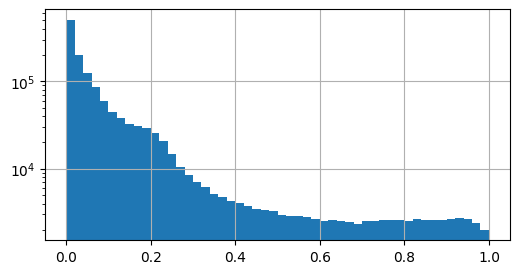

In [ ]:
plt.figure(figsize=(6, 3))
mut_iqtree.ProbaFull.hist(bins=50)
plt.yscale("log")
plt.show()

### Proba iqtree without evol coef

In [ ]:
msum_pr = mutations_summary(mut_iqtree_no_coef, "Gene", "ProbaFull")
msum_pr.round(1)

,non-syn,syn,syn4f,Stop loss,Stop gain,Stop to stop
Gene,,,,,,
1,10678.2,137377.5,73472.4,30.7,26.4,0.0


#### Filtration of IQTREE by probability

In [ ]:
_mtypes_cnt = mut_iqtree_no_coef.groupby("Label").ProbaFull.sum()
print("IQTREE: {:.5f}% of all sbs are stop loss/gain sbs".format(_mtypes_cnt[[-1, -2]].sum() / _mtypes_cnt.sum()))

IQTREE: 0.00039% of all sbs are stop loss/gain sbs


In [ ]:
_mtypes_cnt = mut_iqtree_no_coef[mut_iqtree_no_coef.ProbaFull > 0.1].groupby("Label").ProbaFull.sum()
print("IQTREE filtered: {:.5f}% of all sbs are stop loss/gain sbs".format(_mtypes_cnt[[-1, -2]].sum() / _mtypes_cnt.sum()))
_mtypes_cnt

IQTREE filtered: 0.00010% of all sbs are stop loss/gain sbs


Label
-2        6.638465
-1        5.551561
 0     8572.277534
 1    55396.344860
 2    56694.247221
Name: ProbaFull, dtype: float64

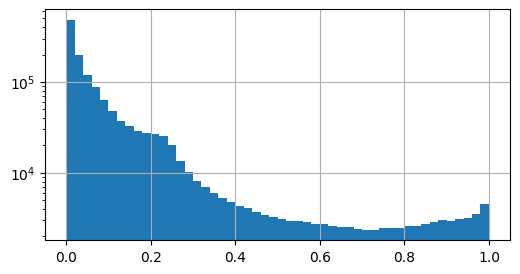

In [ ]:
plt.figure(figsize=(6, 3))
mut_iqtree_no_coef.ProbaFull.hist(bins=50)
plt.yscale("log")
plt.show()

### Proba pastml

In [ ]:
msum_pr = mutations_summary(mut_pastml, "Gene", "ProbaFull")
msum_pr["syn"] += msum_pr["syn4f"]
msum_pr.round(1)

,non-syn,syn,syn4f,Stop loss,Stop gain,Stop to stop
Gene,,,,,,
1,11239.1,213700.1,68323.1,49.0,43.8,0.1


#### Filtration of PASTML by probability

In [ ]:
_mtypes_cnt = mut_pastml.groupby("Label").ProbaFull.sum()
print("PASTML: {:.5f}% of all sbs are stop loss/gain sbs".format(_mtypes_cnt[[-1, -2]].sum() / _mtypes_cnt.sum()))
_mtypes_cnt

PASTML: 0.00059% of all sbs are stop loss/gain sbs


Label
-3        0.065414
-2       48.993138
-1       43.782216
 0    11239.064940
 1    77053.806425
 2    68323.146604
Name: ProbaFull, dtype: float64

In [ ]:
_mtypes_cnt = mut_pastml[mut_pastml.ProbaFull > 0.1].groupby("Label").ProbaFull.sum()
print("PASTML filtered: {:.5f}% of all sbs are stop loss/gain sbs".format(_mtypes_cnt[[-1, -2]].sum() / _mtypes_cnt.sum()))
_mtypes_cnt

PASTML filtered: 0.00008% of all sbs are stop loss/gain sbs


Label
-2        5.845717
-1        4.096485
 0     8606.569125
 1    65687.636905
 2    53729.970008
Name: ProbaFull, dtype: float64

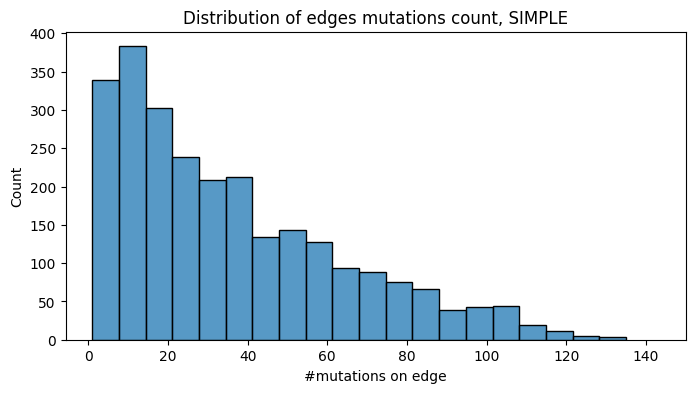

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(mut_simple.AltNode.value_counts(), bins=20)
plt.title("Distribution of edges mutations count, SIMPLE")
plt.xlabel("#mutations on edge")
plt.xlim(None, 150)
plt.show()

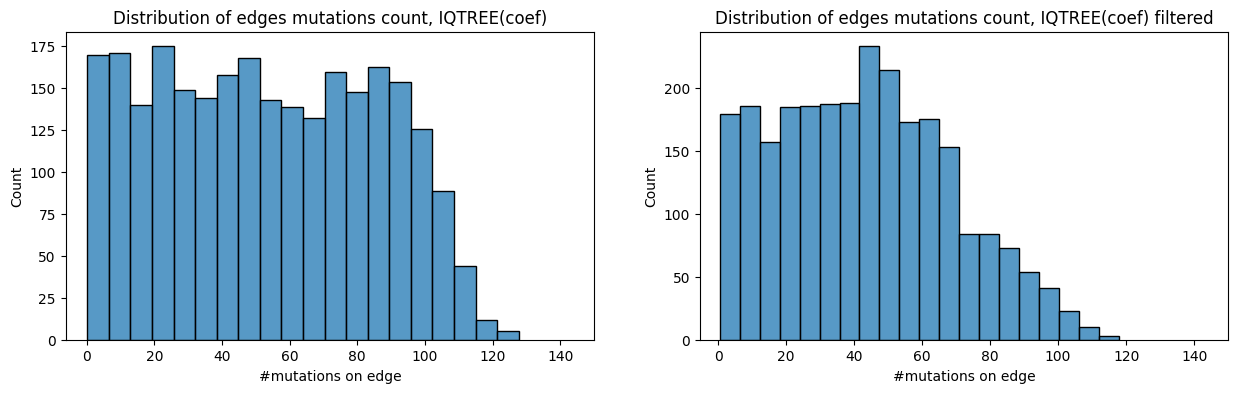

In [ ]:
plt.figure(figsize=(15, 4))
plt.subplot(121)
sns.histplot(mut_iqtree.groupby("AltNode").ProbaFull.sum(), bins=20)
plt.title("Distribution of edges mutations count, IQTREE(coef)")
plt.xlabel("#mutations on edge")
plt.xlim(None, 150)
plt.subplot(122)
sns.histplot(mut_iqtree[mut_iqtree.ProbaFull > 0.1].groupby("AltNode").ProbaFull.sum(), bins=20)
plt.title("Distribution of edges mutations count, IQTREE(coef) filtered")
plt.xlabel("#mutations on edge")
plt.xlim(None, 150)
plt.show()

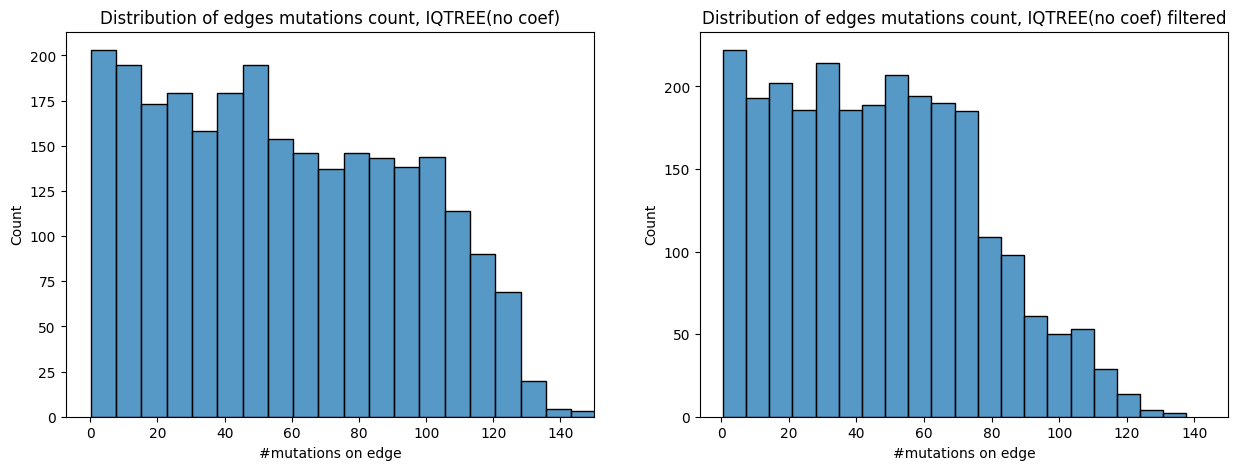

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.histplot(mut_iqtree_no_coef.groupby("AltNode").ProbaFull.sum(), bins=20)
plt.title("Distribution of edges mutations count, IQTREE(no coef)")
plt.xlabel("#mutations on edge")
plt.xlim(None, 150)
plt.subplot(122)
sns.histplot(mut_iqtree_no_coef[mut_iqtree_no_coef.ProbaFull > 0.1].groupby("AltNode").ProbaFull.sum(), bins=20)
plt.title("Distribution of edges mutations count, IQTREE(no coef) filtered")
plt.xlabel("#mutations on edge")
plt.xlim(None, 150)
plt.show()

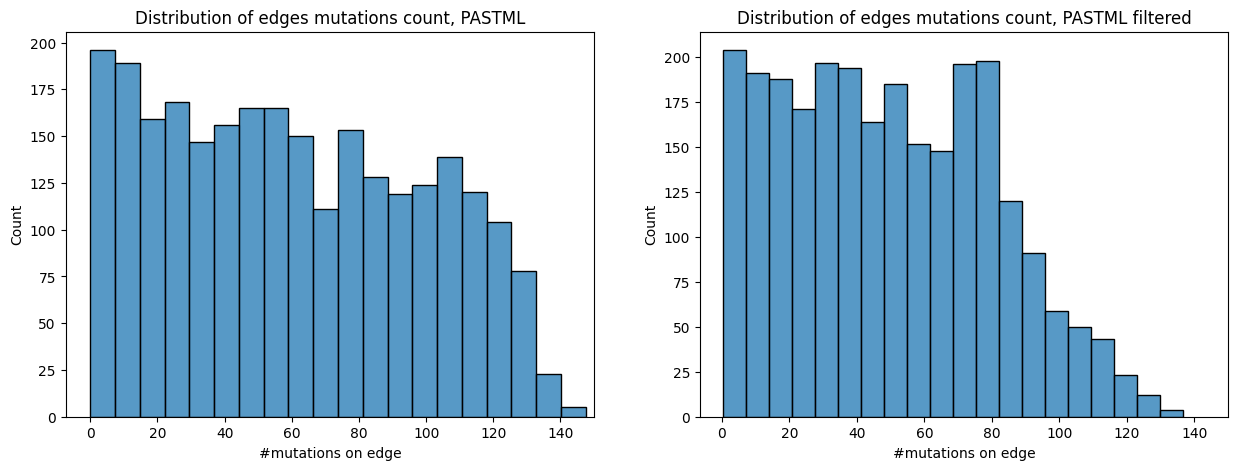

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.histplot(mut_pastml.groupby("AltNode").ProbaFull.sum(), bins=20)
plt.title("Distribution of edges mutations count, PASTML")
plt.xlabel("#mutations on edge")
plt.xlim(None, 150)
plt.subplot(122)
sns.histplot(mut_pastml[mut_pastml.ProbaFull > 0.1].groupby("AltNode").ProbaFull.sum(), bins=20)
plt.title("Distribution of edges mutations count, PASTML filtered")
plt.xlabel("#mutations on edge")
plt.xlim(None, 150)
plt.show()

## Mutspec

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


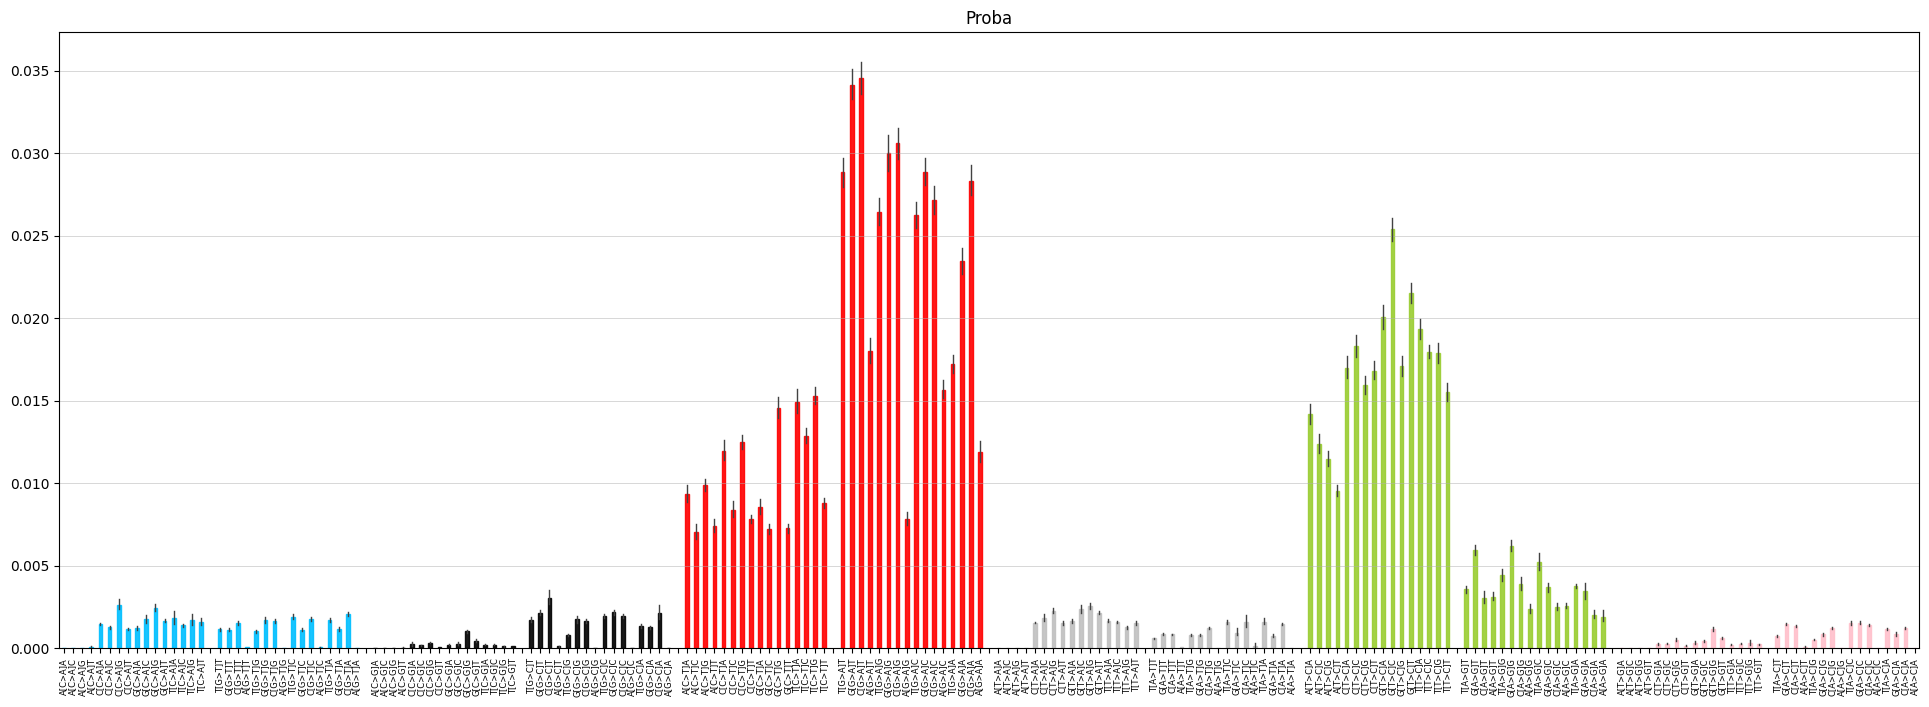

In [ ]:
plot_mutspec192(mutspec_iqtree192, title="Proba")

### Edges Cossim

In [ ]:
# 12
# choose edges with more than or equal to 10 observed mutations to compare 12-comp spectra
nmut_threshhold12 = 10

edges_muts_simple12 = mutspec_simple12[mutspec_simple12.Label == "syn"].groupby("AltNode").ObsNum.sum().sort_values()
edges_muts_iqtree12 = mutspec_iqtree12[mutspec_iqtree12.Label == "syn"].groupby("AltNode").ObsNum.sum().sort_values()
edges_muts_pastml12 = mutspec_pastml12[mutspec_pastml12.Label == "syn"].groupby("AltNode").ObsNum.sum().sort_values()

altnodes_simple12 = list(edges_muts_simple12[edges_muts_simple12 >= nmut_threshhold12].index.values)
altnodes_iqtree12 = list(edges_muts_iqtree12[edges_muts_iqtree12 >= nmut_threshhold12].index.values)
altnodes_pastml12 = list(edges_muts_pastml12[edges_muts_pastml12 >= nmut_threshhold12].index.values)

altnodes_full12 = set(altnodes_simple12).intersection(altnodes_iqtree12).intersection(altnodes_pastml12)
print("#edges =", len(altnodes_full12))

mutspec_simple12_wide = mutspec_simple12[mutspec_simple12.AltNode.isin(altnodes_full12)].pivot(["RefNode", "AltNode", "Label"], "Mut", "MutSpec")
mutspec_iqtree12_wide = mutspec_iqtree12[mutspec_iqtree12.AltNode.isin(altnodes_full12)].pivot(["RefNode", "AltNode", "Label"], "Mut", "MutSpec")
mutspec_pastml12_wide = mutspec_pastml12[mutspec_pastml12.AltNode.isin(altnodes_full12)].pivot(["RefNode", "AltNode", "Label"], "Mut", "MutSpec")

# check that we can compare tables directly
assert np.all(mutspec_simple12_wide.index == mutspec_iqtree12_wide.index)
assert np.all(mutspec_pastml12_wide.index == mutspec_iqtree12_wide.index)
assert np.all(mutspec_simple12_wide.columns == mutspec_iqtree12_wide.columns)
assert np.all(mutspec_pastml12_wide.columns == mutspec_iqtree12_wide.columns)

#edges = 2016


In [ ]:
# 192
# choose edges with more than or equal to 50 observed mutations to compare 192-comp spectra
nmut_threshhold192 = 50

edges_muts_simple192 = mutspec_simple192[mutspec_simple192.Label == "syn"].groupby("AltNode").ObsNum.sum().sort_values()
edges_muts_iqtree192 = mutspec_iqtree192[mutspec_iqtree192.Label == "syn"].groupby("AltNode").ObsNum.sum().sort_values()
edges_muts_pastml192 = mutspec_pastml192[mutspec_pastml192.Label == "syn"].groupby("AltNode").ObsNum.sum().sort_values()

altnodes_simple192 = list(edges_muts_simple192[edges_muts_simple192 >= nmut_threshhold192].index.values)
altnodes_iqtree192 = list(edges_muts_iqtree192[edges_muts_iqtree192 >= nmut_threshhold192].index.values)
altnodes_pastml192 = list(edges_muts_pastml192[edges_muts_pastml192 >= nmut_threshhold192].index.values)

altnodes_full192 = set(altnodes_simple192).intersection(altnodes_iqtree192).intersection(altnodes_pastml192)
print("#edges =", len(altnodes_full192))

mutspec_simple192_wide = mutspec_simple192[mutspec_simple192.AltNode.isin(altnodes_full192)].pivot(["RefNode", "AltNode", "Label"], "Mut", "MutSpec")
mutspec_iqtree192_wide = mutspec_iqtree192[mutspec_iqtree192.AltNode.isin(altnodes_full192)].pivot(["RefNode", "AltNode", "Label"], "Mut", "MutSpec")
mutspec_pastml192_wide = mutspec_pastml192[mutspec_pastml192.AltNode.isin(altnodes_full192)].pivot(["RefNode", "AltNode", "Label"], "Mut", "MutSpec")

# check that we can compare tables directly
assert np.all(mutspec_simple192_wide.index == mutspec_iqtree192_wide.index)
assert np.all(mutspec_pastml192_wide.index == mutspec_iqtree192_wide.index)
assert np.all(mutspec_simple192_wide.columns == mutspec_iqtree192_wide.columns)
assert np.all(mutspec_pastml192_wide.columns == mutspec_iqtree192_wide.columns)

#edges = 594


In [ ]:
mutspec_simple12_wide.head()

Mut                          A>C       A>G       A>T       C>A       C>G  \
RefNode AltNode  Label                                                     
Node1   Node1320 all    0.016202  0.081011  0.048607  0.031012  0.000000   
                 ff     0.000000  0.028205  0.042307  0.019287  0.000000   
                 syn    0.000000  0.037497  0.058867  0.026836  0.000000   
                 syn_c  0.000000  0.040990  0.040990  0.011021  0.000000   
        RN_1     all    0.000000  0.191701  0.023963  0.022933  0.022933   

Mut                          C>T       G>A       G>C  G>T       T>A       T>C  \
RefNode AltNode  Label                                                          
Node1   Node1320 all    0.465175  0.083254  0.041627  0.0  0.016651  0.216461   
                 ff     0.405026  0.262303  0.000000  0.0  0.048575  0.194298   
                 syn    0.302465  0.260696  0.000000  0.0  0.067588  0.246050   
                 syn_c  0.330638  0.284978  0.000000  0.0  0.022414  0.268968   
        RN_1     all    0.504521  0.061566  0.000000  0.0  0.000000  0.172384   

Mut                     T>G  
RefNode AltNode  Label       
Node1   Node1320 all    0.0  
                 ff     0.0  
                 syn    0.0  
                 syn_c  0.0  
        RN_1     all    0.0

In [ ]:
def get_cossim(a: pd.DataFrame, b: pd.DataFrame):
    dotprod = (a * b).sum(axis=1)
    a_norm = (a ** 2).sum(axis=1) ** 0.5
    b_norm = (b ** 2).sum(axis=1) ** 0.5
    cossim = dotprod / (a_norm * b_norm)
    return cossim

get_cossim(mutspec_simple12_wide, mutspec_iqtree12_wide)

RefNode  AltNode   Label
Node1    Node1320  all      0.929104
                   ff       0.903275
                   syn      0.905798
                   syn_c    0.912819
         RN_1      all      0.854627
                              ...   
Node998  RN_711    syn_c    0.999455
Node999  RN_718    all      0.987742
                   ff       0.936494
                   syn      0.948167
                   syn_c    0.972608
Length: 8064, dtype: float64

In [ ]:
# 12
cossim12_total = pd.concat([
    get_cossim(mutspec_simple12_wide, mutspec_iqtree12_wide).rename("Cossim").reset_index().assign(Pair="simple_vs_iqtree"), 
    get_cossim(mutspec_simple12_wide, mutspec_pastml12_wide).rename("Cossim").reset_index().assign(Pair="simple_vs_pastml"), 
    get_cossim(mutspec_iqtree12_wide, mutspec_pastml12_wide).rename("Cossim").reset_index().assign(Pair="iqtree_vs_pastml"),
], ignore_index=True)

# 192
cossim192_total = pd.concat([
    get_cossim(mutspec_simple192_wide, mutspec_iqtree192_wide).rename("Cossim").reset_index().assign(Pair="simple_vs_iqtree"), 
    get_cossim(mutspec_simple192_wide, mutspec_pastml192_wide).rename("Cossim").reset_index().assign(Pair="simple_vs_pastml"), 
    get_cossim(mutspec_iqtree192_wide, mutspec_pastml192_wide).rename("Cossim").reset_index().assign(Pair="iqtree_vs_pastml"),
], ignore_index=True)

In [ ]:
# concat 12 and 192
cossim12_total["ncomp"] = 12
cossim192_total["ncomp"] = 192
cossim_total = pd.concat([cossim12_total, cossim192_total], ignore_index=True)
cossim_total["Label"] = cossim_total["Label"].replace({"ff":"syn4f"})

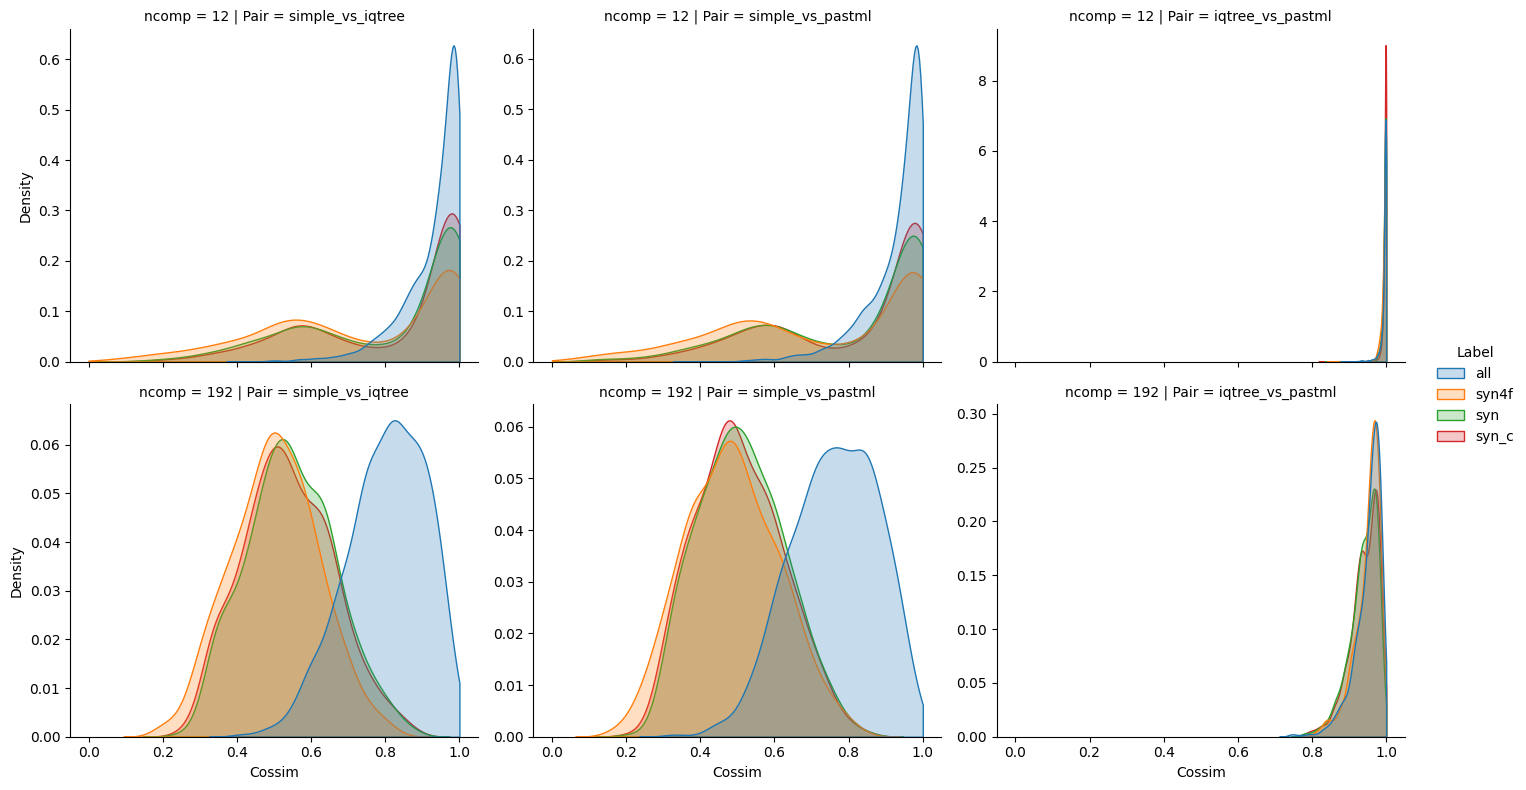

In [ ]:
sns.displot(
    data=cossim_total,
    x="Cossim", hue="Label", col="Pair", row="ncomp", 
    kind="kde", fill=True, clip=(0, 1), height=4, aspect=1.2,
    facet_kws=dict(sharex=True, sharey=False), 
);

### Check updated approach (code)

In [45]:
def complete_sbs192_columns(df: pd.DataFrame):
    df = df.copy()
    if len(df.columns) != 192:
        for sbs192 in set(possible_sbs192).difference(df.columns.values):
            df[sbs192] = 0.
    df = df[possible_sbs192]
    return df


def jackknife_spectra_sampling(obs: pd.DataFrame, exp: pd.DataFrame, frac=0.5, n=1000):
    if len(obs.columns) == 192 and (obs.columns == possible_sbs192).all() and (exp.columns == possible_sbs192).all():
        assert obs.index.names == ["RefNode", "AltNode"]
        assert exp.index.names == ["Node"]
        altnodes  = obs.index.get_level_values(1).values
        obs_edges = obs
        freqs_nodes = exp
        obs_edges.index = obs_edges.index.reorder_levels(order=["AltNode", "RefNode"])
        freqs_nodes.index.name = "RefNode"
    else:
        altnodes = obs.AltNode.unique()
        obs_edges = obs.groupby(["AltNode", "RefNode", "Mut"]).ProbaFull.sum().unstack()
        obs_edges = complete_sbs192_columns(obs_edges)
        freqs_nodes = exp.rename(columns={"Node": "RefNode"}).groupby(["RefNode", "Mut"]).Proba.sum().unstack()
        freqs_nodes = complete_sbs192_columns(freqs_nodes)

    edges_sample_size = int(len(altnodes) * frac)
    spectra = []
    for _ in range(n):
        altnodes_sample = np.random.choice(altnodes, edges_sample_size, False)
        obs_sample = obs_edges.loc[altnodes_sample].reset_index(0, drop=True)
        exp_sample = freqs_nodes.loc[obs_sample.index]
        
        obs_sample_cnt = obs_sample.sum()
        exp_sample_cnt = exp_sample.sum()

        assert (obs_sample_cnt.index == exp_sample_cnt.index).all()

        sample_spectra = obs_sample_cnt / exp_sample_cnt
        spectra.append(sample_spectra)

    return pd.DataFrame(spectra).fillna(0.)


def collapse_sbs192(df: pd.DataFrame, to=12):
    assert (df.columns == possible_sbs192).all()
    df = df.copy()
    if to == 12:
        for sbs192 in possible_sbs192:
            sbs12 = sbs192[2:5]
            if sbs12 in df.columns.values:
                df[sbs12] += df[sbs192]
            else:
                df[sbs12] = df[sbs192]

        return df[possible_sbs12]
    else:
        raise NotImplementedError()


def calc_edgewise_spectra(obs: pd.DataFrame, exp: pd.DataFrame, nmtypes_cutoff=16, nobs_cuttof=20, collapse_to_12=False):
    if len(obs.columns) == 192 and (obs.columns == possible_sbs192).all() and (exp.columns == possible_sbs192).all():
        assert obs.index.names == ["RefNode", "AltNode"]
        assert exp.index.names == ["Node"]
        obs_edges = obs
        freqs_nodes = exp
        freqs_nodes.index.name = "RefNode"
    else:
        obs_edges = obs.groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack()
        obs_edges = complete_sbs192_columns(obs_edges)
        freqs_nodes = exp.groupby(["Node", "Mut"]).Proba.sum().unstack()
        freqs_nodes.index.name = "RefNode"
        freqs_nodes = complete_sbs192_columns(freqs_nodes)

    if not collapse_to_12:
        obs_edges = obs_edges[((obs_edges > 0).sum(axis=1) >= nmtypes_cutoff) & (obs_edges.sum(axis=1) > nobs_cuttof)]
    
    edges_df = obs_edges.index.to_frame(False)

    freqs_edges = edges_df.merge(freqs_nodes, on="RefNode")\
        .set_index(["RefNode", "AltNode"])[possible_sbs192]
    
    assert (obs_edges.columns == freqs_edges.columns).all()
    assert (obs_edges.index == freqs_edges.index).all()

    if collapse_to_12:
        obs_edges   = collapse_sbs192(obs_edges, to=12)
        freqs_edges = collapse_sbs192(freqs_edges, to=12)

    spectra = (obs_edges / freqs_edges).replace(np.inf, 0.).fillna(0.)
    spectra = (spectra.T / spectra.T.sum(axis=0)).T

    assert not (spectra == np.inf).any().any()
    assert not (spectra.isna()).any().any()

    return spectra


def assign_cat(p: float, interval=0.1):
    if interval < 0.01:
        raise NotImplementedError
    
    left = p // interval / (1 / interval)
    right = left + interval
    if interval >= 0.1:
        return f"{left:.1f}_{right:.1f}"
    else:
        return f"{left:.2f}_{right:.2f}"


def get_cossim(a: pd.DataFrame, b: pd.DataFrame):
    assert (a.columns == b.columns).all()
    
    common_index = a.index.intersection(b.index)
    if len(common_index) == 0:
        return pd.Series()
    
    a = a.loc[common_index]
    b = b.loc[common_index]

    dotprod = (a * b).sum(axis=1)
    a_norm = (a ** 2).sum(axis=1) ** 0.5
    b_norm = (b ** 2).sum(axis=1) ** 0.5
    cossim = dotprod / (a_norm * b_norm)
    return cossim

In [9]:
path_to_data = "../data/exposure/mammals_cytb/"

new_mutations_simple = pd.read_csv(os.path.join(path_to_data, "gtr_simple/mutations.tsv"), sep='\t').assign(ProbaFull=1.0)
new_mutations_iqtree = pd.read_csv(os.path.join(path_to_data, "gtr_proba_v2/mutations.tsv"), sep='\t')
new_mutations_pastml = pd.read_csv(os.path.join(path_to_data, "pastml/mutations.tsv"), sep='\t')

new_exp_freqs_simple = pd.read_csv(os.path.join(path_to_data, "gtr_simple/expected_freqs.tsv"), sep='\t')
new_exp_freqs_iqtree = pd.read_csv(os.path.join(path_to_data, "gtr_proba_v2/expected_freqs.tsv"), sep='\t')
new_exp_freqs_pastml = pd.read_csv(os.path.join(path_to_data, "pastml/expected_freqs.tsv"), sep='\t')

new_exp_muts_simple = pd.read_csv(os.path.join(path_to_data, "gtr_simple/expected_mutations.tsv"), sep='\t').assign(Proba=1.0)
new_exp_muts_iqtree = pd.read_csv(os.path.join(path_to_data, "gtr_proba_v2/expected_mutations.tsv"), sep='\t')
new_exp_muts_pastml = pd.read_csv(os.path.join(path_to_data, "pastml/expected_mutations.tsv"), sep='\t')

In [10]:
exp_freqs_iqtree_v2 = complete_sbs192_columns(new_exp_muts_iqtree[new_exp_muts_iqtree.Label=="syn"]\
                                              .groupby(["Node", "Mut"]).Proba.sum().unstack())[possible_sbs192]

In [11]:
dtypes_rate = {"Site": np.int16, "Cat": np.int8}
rate_cytb = pd.read_csv("../data/exposure/mammals_cytb/states/gtr.rate", comment="#", sep="\t", dtype=dtypes_rate)
sites_fast = set(rate_cytb[rate_cytb.Cat > 4].Site.values)
print(len(sites_fast), "variable sites from", len(rate_cytb))
rate_cytb.head()

362 variable sites from 1140


,Site,Rate,Cat,C_Rate
0,1,0.00187,0,0.00000
1,2,0.00003,0,0.00000
2,3,0.01569,1,0.01569
3,4,0.19571,2,0.12291
4,5,0.37341,3,0.37341


#### Is aggregation of exp mutations works correctly?
yes

In [ ]:
coda = CodonAnnotation(2)

In [ ]:
exp_freqs_iqtree_v2.head()

Mut,A[A>C]A,A[A>C]C,A[A>C]G,A[A>C]T,C[A>C]A,C[A>C]C,C[A>C]G,C[A>C]T,G[A>C]A,G[A>C]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Node,,,,,,,,,,,,,,,,,,,,,
Node1,0.0,0.0,0.0,0.0,5.579872,7.583202,15.338511,14.099052,NaN,3.609110,...,3.152523,3.958562,0.331007,0.808515,0.981607,1.803806,3.221463,5.742644,1.677888,1.462636
Node10,0.0,0.0,0.0,0.0,6.715408,3.095777,18.419607,13.634721,2.418048,4.188804,...,NaN,1.381574,NaN,0.583307,NaN,0.874085,1.409116,3.945686,1.112634,1.017936
Node100,0.0,0.0,0.0,0.0,9.769916,3.450238,16.074040,16.109629,2.631126,2.546726,...,1.081793,2.288904,1.020297,1.385102,0.967659,1.653862,2.763304,5.785828,1.676878,0.242777
Node1000,0.0,0.0,0.0,0.0,8.608549,7.589105,14.290013,14.814883,3.189168,1.062507,...,1.608747,2.399286,0.177986,0.947268,0.763245,1.696455,2.300584,3.429443,0.970238,1.213955
Node1001,0.0,0.0,0.0,0.0,6.335181,8.117199,16.338388,13.361483,2.609898,2.240646,...,2.516093,2.674544,1.107430,0.385377,1.244117,2.218236,2.853173,2.513601,1.192397,1.048808


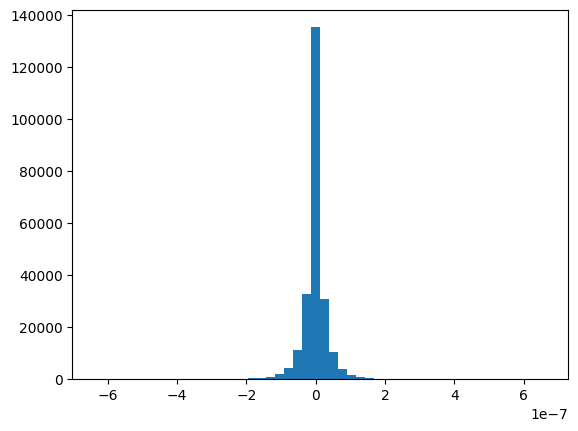

In [ ]:
plt.hist((new_exp_freqs_iqtree[new_exp_freqs_iqtree.Label=="syn"]\
          .set_index("Node")[possible_sbs192].loc[exp_freqs_iqtree_v2.index] - exp_freqs_iqtree_v2).values.flatten(), bins=50);

In [ ]:
seq = """ATGGCAGCCCCCCGCAAAACACATCCACTAATAAAAATTATCAACAGCTCATTCATTGACCTTCCCACACCACCCAATATCTCGTCCTGATGAAACTTCGGCTCACTTCTAGGCATCTGCCTAATTATTCAAATCATCACAGGCCTATTCTTAGCTATACATTACACATCAGATTCTTCCAC
TGCTTTCTCCTCAGTCGCCCATATCACCCGAGATGTAAACTACGGCTGAATAGTGCGCTACCTACACGCCAACGGCGCCTCCCTATTCTTCATATGTCTATTTCTTCACATTGGACGGGGCATGTACTACGGATCCTTTCTCTTTCTAAATACATGAAACATTGGCATCATTTTATTACTTA
CAACTATAGCCACAGCATTTATAGGCTATGTACTCCCATGAGGCCAAATATCCTTCTGAGGAGCCACAGTAATCACAAACCTTCTATCAGCTATCCCATATATTGGACCTGACTTAGTACAATGAATCTGAGGTGGCTTTTCCGTTGATAAAGCCACCCTAACTCGATTTTTTACCTTCCAC
TTTATCTTGCCCTTCATTATTGCAGCCCTAGCATCTATTCACCTTCTGTTTCTGCATGACACAGGTTCAAATAATCCATCAGGACTGACATCTGATCCAGACAAAGTCTCATTCCACCCATACTATACAATCAAAGATATCTTAGGCTTAGTTTTCCTGCTTCTACTTTTAATAAGCCTAAC
CCTATTTATACCCGATCTTTTAACAGACCCAGACAACTACACCCCAGCTAACCCCCTAAACACCCCACCACATATTAAACCAGAATGGTACTTTCTATTTGCATACGCAATTCTACGATCCATTCCCAATAAACTAGGAGGCGTCTTAGCCCTTCTTCTATCCATCCTAATCCTAACAATTA
TCCCTATAATACATACATCCAAACAGCAAAGTATAACATTCCGACCCATTAGCCAGAGCCTATTCTGAGCTCTAGTAGCTGACCTATTTACACTCACATGAATTGGAGGCCAGCCAGTTGAGTACCCTTTTATTAGCATTGGCCAAACCGCATCCACCCTATACTTT---CTTATTATTTCT
ATTACTCCCCTACTCGCCCTAATTGAAAACAAACTACTTAAATGGTAG""".replace("\n", "")

m = coda.collect_exp_muts(seq)
f = coda.collect_exp_mut_freqs(seq)[1]["syn"]

In [ ]:
a = pd.Series(f).sort_values(ascending=False).rename("F").to_frame().merge(
    m.value_counts("Mut").rename("M").to_frame(), 
    left_index=True, right_index=True)

In [ ]:
a.T[[x for x in possible_sbs192 if x in a.index.values]].T

,F,M
C[A>C]A,6,6
C[A>C]C,8,8
C[A>C]G,16,16
C[A>C]T,16,16
G[A>C]C,4,4
...,...,...
G[T>G]T,1,1
T[T>G]A,3,3
T[T>G]C,8,8
T[T>G]G,2,2


### Check spectra

error

In [ ]:
mutspec_iqtree192_wide_v2 = calc_edgewise_spectra(new_mutations_iqtree[new_mutations_iqtree.Label > 0], new_exp_muts_iqtree[new_exp_muts_iqtree.Label == "syn"])
mutspec_iqtree192_wide_v2.head()

Mut               A[A>C]A  A[A>C]C  A[A>C]G  A[A>C]T   C[A>C]A   C[A>C]C  \
RefNode AltNode                                                            
Node1   Node1320      0.0      0.0      0.0      0.0  0.000000  0.000000   
        RN_1          0.0      0.0      0.0      0.0  0.000000  0.000000   
Node10  Node389       0.0      0.0      0.0      0.0  0.003927  0.003796   
        Node9         0.0      0.0      0.0      0.0  0.004095  0.002767   
Node100 RN_159        0.0      0.0      0.0      0.0  0.000592  0.001281   

Mut                C[A>C]G   C[A>C]T   G[A>C]A   G[A>C]C  ...   C[T>G]G  \
RefNode AltNode                                           ...             
Node1   Node1320  0.000000  0.000000  0.000000  0.000000  ...  0.000381   
        RN_1      0.000000  0.000000  0.000000  0.000000  ...  0.000000   
Node10  Node389   0.000157  0.000304  0.000000  0.001210  ...  0.000000   
        Node9     0.000144  0.000166  0.000000  0.000579  ...  0.000000   
Node100 RN_159    0.000155  0.000409  0.002795  0.000000  ...  0.000000   

Mut                C[T>G]T  G[T>G]A  G[T>G]C  G[T>G]G   G[T>G]T   T[T>G]A  \
RefNode AltNode                                                             
Node1   Node1320  0.000000      0.0      0.0      0.0  0.000000  0.000000   
        RN_1      0.000000      0.0      0.0      0.0  0.000000  0.000000   
Node10  Node389   0.000000      0.0      0.0      0.0  0.000417  0.000174   
        Node9     0.001606      0.0      0.0      0.0  0.000240  0.000831   
Node100 RN_159    0.000000      0.0      0.0      0.0  0.000000  0.000000   

Mut                T[T>G]C  T[T>G]G   T[T>G]T  
RefNode AltNode                                
Node1   Node1320  0.000000      0.0  0.000000  
        RN_1      0.001989      0.0  0.000000  
Node10  Node389   0.000322      0.0  0.000519  
        Node9     0.000438      0.0  0.000000  
Node100 RN_159    0.002495      0.0  0.000000  

[5 rows x 192 columns]

In [ ]:
a = mutspec_iqtree192_wide.reset_index(2)
a = a[a.Label == "syn"].drop("Label", axis=1)[possible_sbs192]
a.head()

Mut                A[A>C]A  A[A>C]C  A[A>C]G  A[A>C]T   C[A>C]A   C[A>C]C  \
RefNode  AltNode                                                            
Node1    Node1320      0.0      0.0      0.0      0.0  0.000044  0.000078   
Node100  RN_159        0.0      0.0      0.0      0.0  0.000477  0.001434   
         RN_160        0.0      0.0      0.0      0.0  0.000198  0.000486   
Node1006 RN_726        0.0      0.0      0.0      0.0  0.006069  0.004793   
Node1008 RN_603        0.0      0.0      0.0      0.0  0.001501  0.000000   

Mut                 C[A>C]G   C[A>C]T   G[A>C]A   G[A>C]C  ...   C[T>G]G  \
RefNode  AltNode                                           ...             
Node1    Node1320  0.000026  0.000003  0.000000  0.000000  ...  0.000472   
Node100  RN_159    0.000144  0.000366  0.003479  0.000000  ...  0.000000   
         RN_160    0.000130  0.005848  0.002155  0.013706  ...  0.000000   
Node1006 RN_726    0.000000  0.000000  0.000000  0.000000  ...  0.000000   
Node1008 RN_603    0.008374  0.002545  0.000000  0.000000  ...  0.000000   

Mut                C[T>G]T   G[T>G]A  G[T>G]C  G[T>G]G  G[T>G]T  T[T>G]A  \
RefNode  AltNode                                                           
Node1    Node1320      0.0  0.000000      0.0      0.0      0.0      0.0   
Node100  RN_159        0.0  0.000521      0.0      0.0      0.0      0.0   
         RN_160        0.0  0.000000      0.0      0.0      0.0      0.0   
Node1006 RN_726        0.0  0.000000      0.0      0.0      0.0      0.0   
Node1008 RN_603        0.0  0.000000      0.0      0.0      0.0      0.0   

Mut                 T[T>G]C  T[T>G]G   T[T>G]T  
RefNode  AltNode                                
Node1    Node1320  0.000000      0.0  0.000126  
Node100  RN_159    0.002286      0.0  0.000000  
         RN_160    0.000000      0.0  0.015388  
Node1006 RN_726    0.000000      0.0  0.000000  
Node1008 RN_603    0.000453      0.0  0.000000  

[5 rows x 192 columns]

<AxesSubplot:>

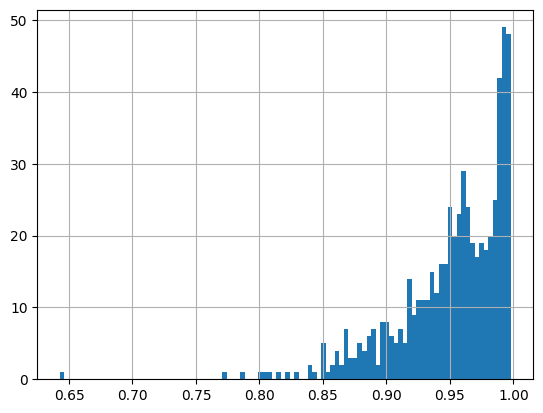

In [ ]:
get_cossim(a, mutspec_iqtree192_wide_v2).hist(bins=100)

### Check one edge **Node10-Node389**

In [ ]:
refnode, altnode = "Node10", "Node389"

# exp_muts = new_exp_muts_iqtree[(new_exp_muts_iqtree.Label == "syn") & (new_exp_muts_iqtree.Node == refnode)]
exp_freqs = exp_freqs_iqtree_v2.loc[refnode].rename("ExpNum_v2")

obs_muts = new_mutations_iqtree[(new_mutations_iqtree.Label > 0) & (new_mutations_iqtree.AltNode == altnode)]
obs_freqs = obs_muts.groupby("Mut").ProbaFull.sum().rename("ObsNum_v2")


spectra = mutspec_iqtree192[(mutspec_iqtree192.Label == "syn") & (mutspec_iqtree192.AltNode == altnode)].merge(
    obs_freqs, left_on="Mut", right_index=True,).merge(exp_freqs, left_on="Mut", right_index=True)


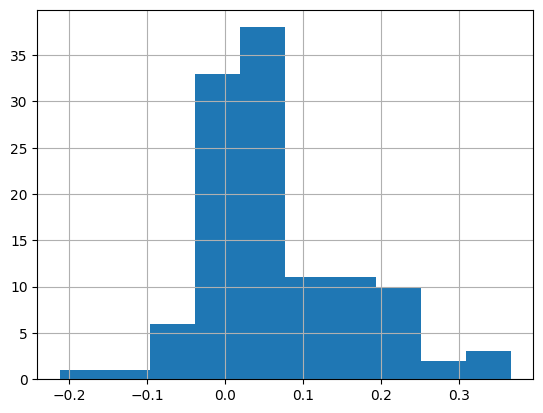

In [ ]:
(spectra.ObsNum - spectra.ObsNum_v2).hist();

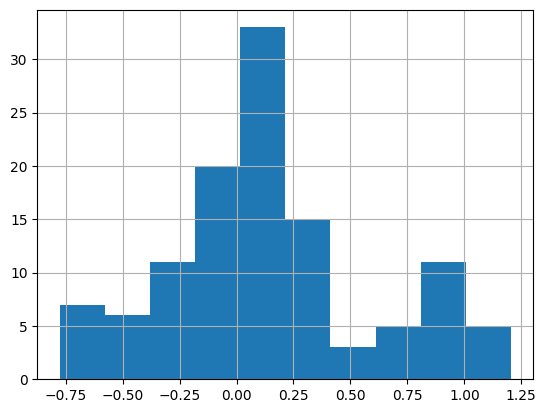

In [ ]:
(spectra.ExpNum - spectra.ExpNum_v2).hist();

<AxesSubplot:xlabel='Mut'>

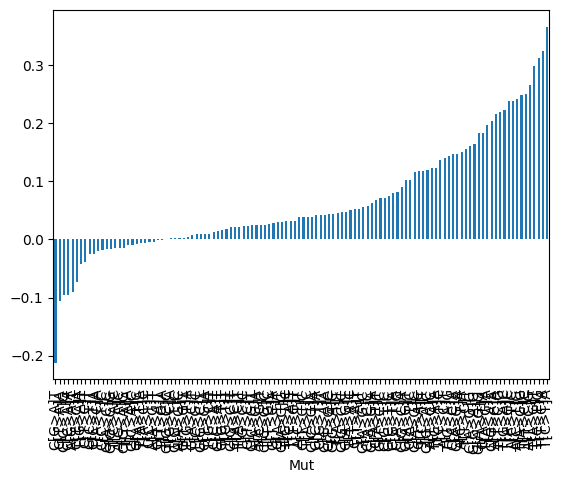

In [ ]:
d = pd.merge(
    mut_iqtree[(mut_iqtree.RefNode == refnode) & (mut_iqtree.AltNode == altnode) & (mut_iqtree.Label >= 1)].groupby("Mut").ProbaFull.sum().rename("Legacy"),
    new_mutations_iqtree[(new_mutations_iqtree.RefNode == refnode) & 
                         (new_mutations_iqtree.AltNode == altnode) & 
                         (new_mutations_iqtree.Label >= 1)].groupby("Mut").ProbaFull.sum().rename("New"),
    right_index=True, left_index=True,
)
d["Diff"] = d.Legacy - d.New
d.Diff.sort_values().plot.bar();

In [ ]:
mut_iqtree[(mut_iqtree.RefNode == refnode) & (mut_iqtree.AltNode == altnode) & (mut_iqtree.Label >= 1) & (mut_iqtree.ProbaFull > 0.3)]#.groupby("Mut").ProbaFull.sum().rename("Legacy"),


,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,ProbaRef,ProbaMut,ProbaFull,RefNode,AltNode,Gene,MutBase
200769,T[C>T]T,1,81,3,ATC,ATT,I,I,0.614480,0.449302,0.378177,Node10,Node389,1,C>T
200970,C[T>A]A,2,252,3,GCT,GCA,A,A,0.667360,0.560936,0.472139,Node10,Node389,1,T>A
201005,T[G>A]C,2,288,3,CTG,CTA,L,L,0.837318,0.375532,0.316085,Node10,Node389,1,G>A
201041,A[C>T]T,1,309,3,TAC,TAT,Y,Y,0.888800,0.391125,0.329210,Node10,Node389,1,C>T
201193,C[T>A]A,2,429,3,GCT,GCA,A,A,0.842450,0.643135,0.541326,Node10,Node389,1,T>A
201257,T[C>T]T,1,504,3,TTC,TTT,F,F,0.903340,0.434127,0.365404,Node10,Node389,1,C>T
201416,T[C>T]C,1,660,3,TTC,TTT,F,F,0.741330,0.387634,0.326271,Node10,Node389,1,C>T
201672,C[C>A]C,2,792,3,ACC,ACA,T,T,0.429700,0.358980,0.302153,Node10,Node389,1,C>A
201675,C[T>A]C,2,792,3,ACT,ACA,T,T,0.557250,0.465538,0.391843,Node10,Node389,1,T>A
201708,C[G>A]T,2,831,3,GCG,GCA,A,A,0.788940,0.386312,0.325159,Node10,Node389,1,G>A


### Check all edges

In [12]:
a = new_mutations_iqtree[(new_mutations_iqtree.Label >= 1) & (new_mutations_iqtree.ProbaFull > 0.3)].groupby(["AltNode", "Mut"]).ProbaFull.sum().unstack().fillna(0)
b = mut_iqtree[(mut_iqtree.Label >= 1) & (mut_iqtree.ProbaFull > 0.3)].groupby(["AltNode", "Mut"]).ProbaFull.sum().unstack().fillna(0)
a.head()

Mut,A[A>G]A,A[A>G]C,A[A>G]G,A[A>G]T,A[C>T]A,A[C>T]C,A[C>T]G,A[C>T]T,A[G>A]A,A[G>A]C,...,T[T>A]G,T[T>A]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
AltNode,,,,,,,,,,,,,,,,,,,,,
Node1,0.0,0.300554,0.0,0.0,0.824470,1.238776,0.562264,1.094503,0.0,0.358734,...,0.0,0.000000,0.917128,0.807523,0.387914,0.496468,0.0,0.000000,0.0,0.0
Node10,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.486134,0.0,0.0
Node100,0.0,0.000000,0.0,0.0,1.076123,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.322272,1.217917,0.685947,0.000000,0.805070,0.0,0.000000,0.0,0.0
Node1000,0.0,0.000000,0.0,0.0,0.335767,0.000000,0.000000,0.385158,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
Node1001,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.368108,0.0,0.000000,...,0.0,0.000000,0.401091,0.000000,0.301757,0.313898,0.0,0.000000,0.0,0.0


In [13]:
assert (a.columns == b.columns).all()

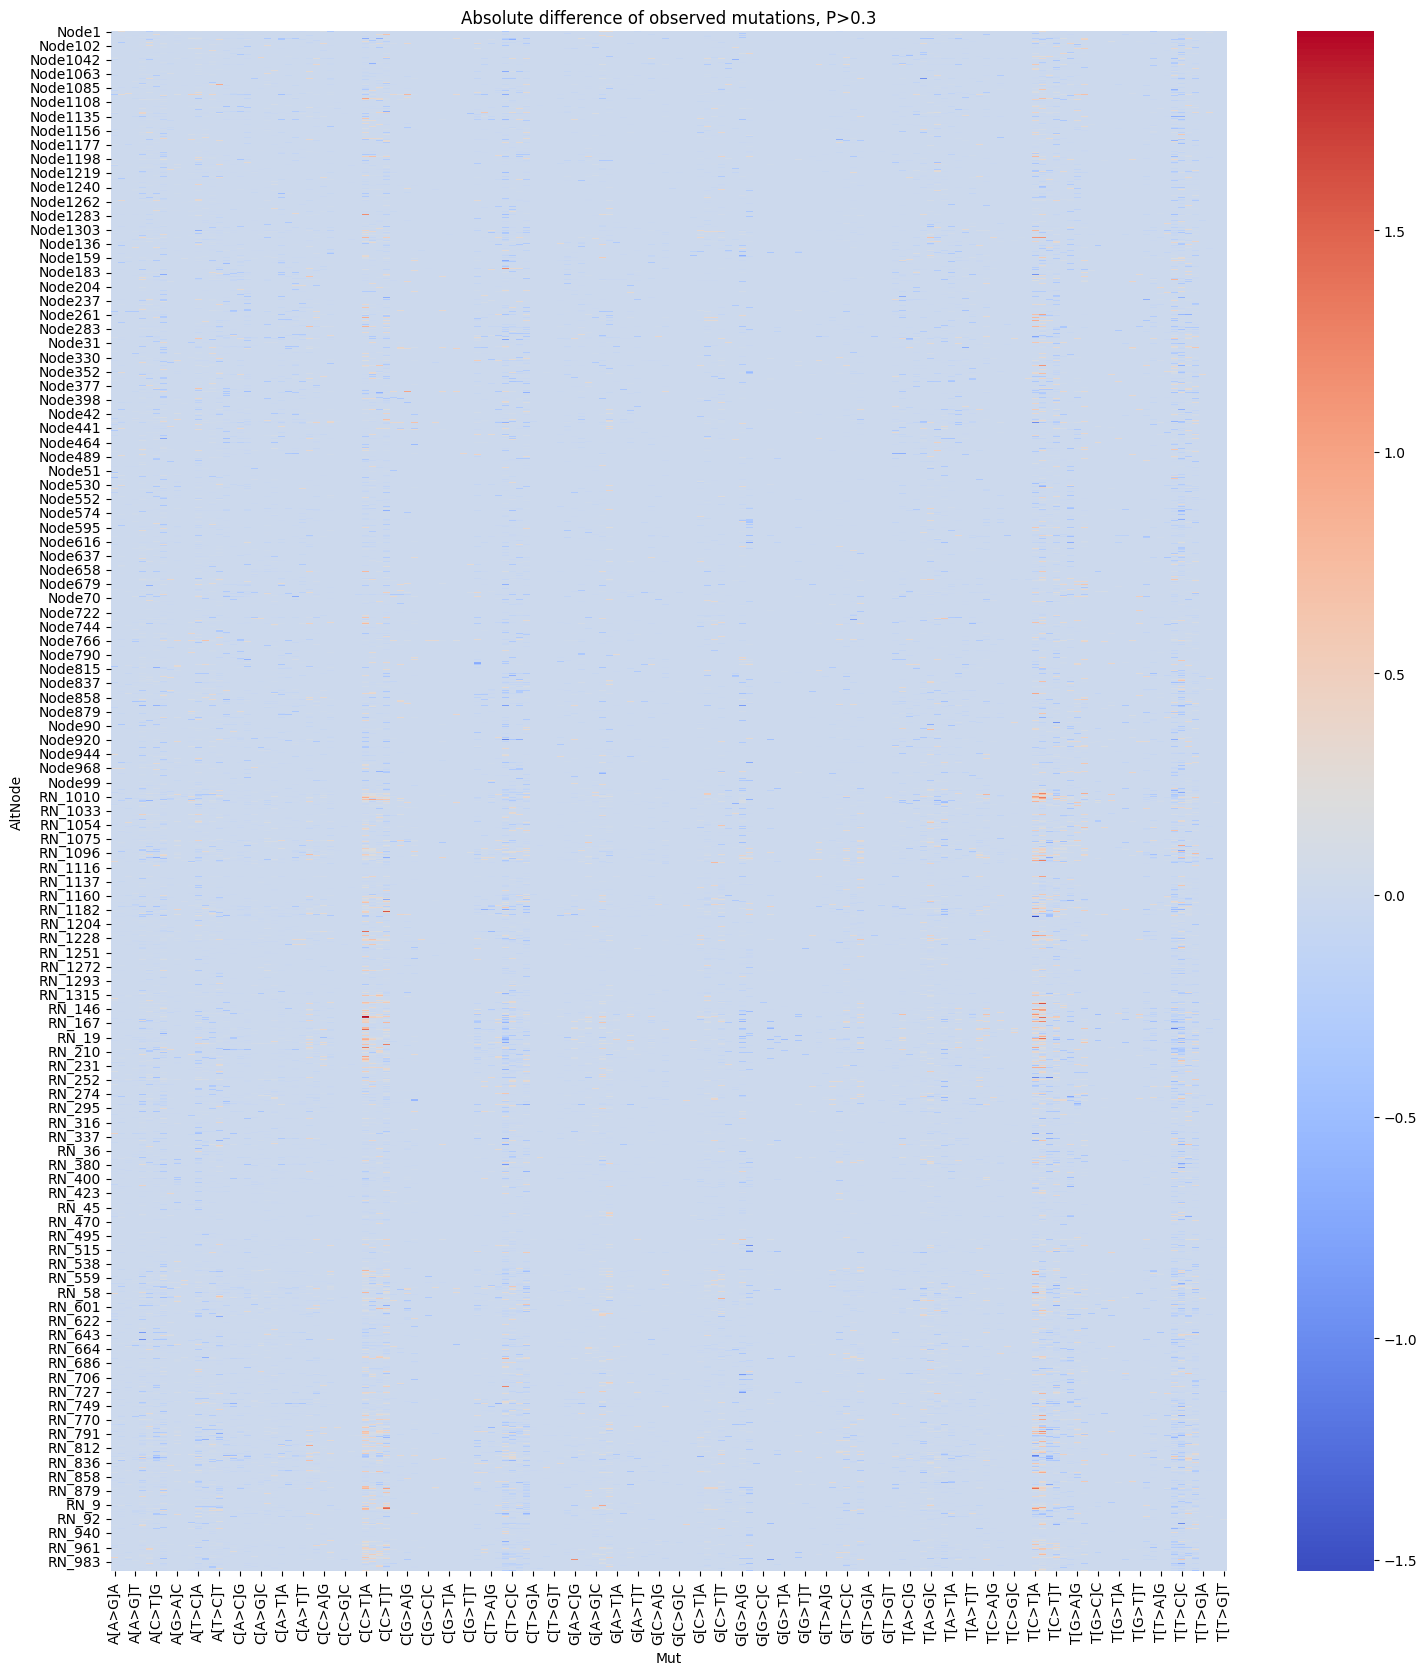

In [ ]:
plt.figure(figsize=(18, 20))
plt.title("Absolute difference of observed mutations, P>0.3")
sns.heatmap(a.loc[a.index.intersection(b.index)] - b.loc[a.index.intersection(b.index)], cmap="coolwarm", );

### Edges Cossim on NEW data

In [14]:
new_mutations_iqtree.head()

,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,ProbaRef,ProbaMut,ProbaFull,RefNode,AltNode,Gene
0,C[C>T]T,1,10,1,CTA,TTA,L,L,0.671149,0.052569,0.042724,Node208,Node209,1
1,C[T>C]T,1,10,1,TTA,CTA,L,L,0.162337,0.136533,0.110961,Node208,Node209,1
2,T[A>G]C,2,12,3,CTA,CTG,L,L,0.691300,0.040622,0.033014,Node208,Node209,1
3,T[G>A]C,2,12,3,CTG,CTA,L,L,0.081715,0.069935,0.056837,Node208,Node209,1
4,G[A>G]A,2,15,3,CGA,CGG,R,R,0.889950,0.135789,0.110357,Node208,Node209,1


In [15]:
new_exp_muts_pastml.head()

,Pos,Pic,Mut,Cdn,Label,Proba,Node,Gene
0,3,3,T[G>A]A,ATG,syn,0.500998,ROOT,1
1,3,3,T[G>A]A,ATG,syn_c,0.500998,ROOT,1
2,3,3,T[G>C]A,ATG,syn_c,0.500998,ROOT,1
3,3,3,T[G>G]A,ATG,syn_c,0.500998,ROOT,1
4,3,3,T[G>T]A,ATG,syn_c,0.500998,ROOT,1


In [34]:
pcutoff = 0.3

new_mutspec192_iqtree = pd.concat([    
    new_mutations_iqtree[(new_mutations_iqtree.Label >= 0) & (new_mutations_iqtree.ProbaFull > pcutoff) & (new_mutations_iqtree.PosInGene.isin(sites_fast))]\
        .groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum()\
            .rename("ObsNum").reset_index().assign(Label="all"),
    new_mutations_iqtree[(new_mutations_iqtree.Label >= 1) & (new_mutations_iqtree.ProbaFull > pcutoff) & (new_mutations_iqtree.PosInGene.isin(sites_fast))]\
        .groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum()\
            .rename("ObsNum").reset_index().assign(Label="syn"),
    new_mutations_iqtree[(new_mutations_iqtree.Label >= 2) & (new_mutations_iqtree.ProbaFull > pcutoff) & (new_mutations_iqtree.PosInGene.isin(sites_fast))]\
        .groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum()\
            .rename("ObsNum").reset_index().assign(Label="syn4f")
], ignore_index=True).merge(
    new_exp_muts_iqtree[(new_exp_muts_iqtree.Proba > pcutoff) & (new_exp_muts_iqtree.Pos.isin(sites_fast))]\
        .groupby(["Node", "Label", "Mut"]).Proba.sum().rename("ExpNum").reset_index(), 
    right_on=["Node", "Label", "Mut"], left_on=["RefNode", "Label", "Mut"], ).drop("Node", axis=1)

new_mutspec192_pastml = pd.concat([    
    new_mutations_pastml[(new_mutations_pastml.Label >= 0) & (new_mutations_pastml.ProbaFull > pcutoff) & (new_mutations_pastml.PosInGene.isin(sites_fast))]\
        .groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum()\
            .rename("ObsNum").reset_index().assign(Label="all"),
    new_mutations_pastml[(new_mutations_pastml.Label >= 1) & (new_mutations_pastml.ProbaFull > pcutoff) & (new_mutations_pastml.PosInGene.isin(sites_fast))]\
        .groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum()\
            .rename("ObsNum").reset_index().assign(Label="syn"),
    new_mutations_pastml[(new_mutations_pastml.Label >= 2) & (new_mutations_pastml.ProbaFull > pcutoff) & (new_mutations_pastml.PosInGene.isin(sites_fast))]\
        .groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum()\
            .rename("ObsNum").reset_index().assign(Label="syn4f")
], ignore_index=True).merge(
    new_exp_muts_pastml[(new_exp_muts_pastml.Proba > pcutoff) & (new_exp_muts_pastml.Pos.isin(sites_fast))]\
        .groupby(["Node", "Label", "Mut"]).Proba.sum().rename("ExpNum").reset_index(), 
    right_on=["Node", "Label", "Mut"], left_on=["RefNode", "Label", "Mut"], ).drop("Node", axis=1)

new_mutspec192_simple = pd.concat([    
    new_mutations_simple[(new_mutations_simple.Label >= 0) & (new_mutations_simple.ProbaFull > pcutoff) & (new_mutations_simple.PosInGene.isin(sites_fast))]\
        .groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum()\
            .rename("ObsNum").reset_index().assign(Label="all"),
    new_mutations_simple[(new_mutations_simple.Label >= 1) & (new_mutations_simple.ProbaFull > pcutoff) & (new_mutations_simple.PosInGene.isin(sites_fast))]\
        .groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum()\
            .rename("ObsNum").reset_index().assign(Label="syn"),
    new_mutations_simple[(new_mutations_simple.Label >= 2) & (new_mutations_simple.ProbaFull > pcutoff) & (new_mutations_simple.PosInGene.isin(sites_fast))]\
        .groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum()\
            .rename("ObsNum").reset_index().assign(Label="syn4f")
], ignore_index=True).merge(
    new_exp_muts_simple[(new_exp_muts_simple.Proba > pcutoff) & (new_exp_muts_simple.Pos.isin(sites_fast))]\
        .groupby(["Node", "Label", "Mut"]).Proba.sum().rename("ExpNum").reset_index(), 
    right_on=["Node", "Label", "Mut"], left_on=["RefNode", "Label", "Mut"], ).drop("Node", axis=1)

for d in [new_mutspec192_iqtree, new_mutspec192_simple, new_mutspec192_pastml]:
    d["MutSpec"] = d.ObsNum / d.ExpNum

new_mutspec192_iqtree.head()

,RefNode,AltNode,Mut,ObsNum,Label,ExpNum,MutSpec
0,Node1,Node1320,A[C>T]A,1.285438,all,8.822874,0.145694
1,Node1,RN_1,A[C>T]A,1.328726,all,8.822874,0.150600
2,Node1,Node1320,A[C>T]C,1.527411,all,6.324848,0.241494
3,Node1,RN_1,A[C>T]C,0.584975,all,6.324848,0.092488
4,Node1,Node1320,A[C>T]G,0.486069,all,4.234040,0.114800


In [68]:
# 192
# choose edges with more than or equal to 50 observed mutations to compare 192-comp spectra
nmuts_thresh = 20
nmut_types_thresh = 16

edges_nmuts_simple192 = new_mutspec192_simple[new_mutspec192_simple.Label == "all"].groupby("AltNode").ObsNum.sum()
edges_nmuts_iqtree192 = new_mutspec192_iqtree[new_mutspec192_iqtree.Label == "all"].groupby("AltNode").ObsNum.sum()
edges_nmuts_pastml192 = new_mutspec192_pastml[new_mutspec192_pastml.Label == "all"].groupby("AltNode").ObsNum.sum()

edges_nmut_types_simple192 = new_mutspec192_simple[(new_mutspec192_simple.Label == "all") & (new_mutspec192_simple.MutSpec > 0)].groupby("AltNode").Mut.nunique()
edges_nmut_types_iqtree192 = new_mutspec192_iqtree[(new_mutspec192_iqtree.Label == "all") & (new_mutspec192_iqtree.MutSpec > 0)].groupby("AltNode").Mut.nunique()
edges_nmut_types_pastml192 = new_mutspec192_pastml[(new_mutspec192_pastml.Label == "all") & (new_mutspec192_pastml.MutSpec > 0)].groupby("AltNode").Mut.nunique()

altnodes_simple192 = list(edges_nmuts_simple192[(edges_nmut_types_simple192 >= nmut_types_thresh) & (edges_nmuts_simple192 >= nmuts_thresh)].index.values)
altnodes_iqtree192 = list(edges_nmuts_iqtree192[(edges_nmut_types_iqtree192 >= nmut_types_thresh) & (edges_nmuts_iqtree192 >= nmuts_thresh)].index.values)
altnodes_pastml192 = list(edges_nmuts_pastml192[(edges_nmut_types_pastml192 >= nmut_types_thresh) & (edges_nmuts_pastml192 >= nmuts_thresh)].index.values)

altnodes_full192 = set(altnodes_simple192).intersection(altnodes_iqtree192).intersection(altnodes_pastml192)
# altnodes_full192 = edges_nmuts_simple192.index
print("#total edges =", len(edges_nmuts_simple192))
print("#used  edges =", len(altnodes_full192))

new_mutspec192_simple_wide = complete_sbs192_columns(new_mutspec192_simple[new_mutspec192_simple.AltNode.isin(altnodes_full192)].pivot(["RefNode", "AltNode", "Label"], "Mut", "MutSpec"))
new_mutspec192_iqtree_wide = complete_sbs192_columns(new_mutspec192_iqtree[new_mutspec192_iqtree.AltNode.isin(altnodes_full192)].pivot(["RefNode", "AltNode", "Label"], "Mut", "MutSpec"))
new_mutspec192_pastml_wide = complete_sbs192_columns(new_mutspec192_pastml[new_mutspec192_pastml.AltNode.isin(altnodes_full192)].pivot(["RefNode", "AltNode", "Label"], "Mut", "MutSpec"))

# check that we can compare tables directly
assert np.all(new_mutspec192_simple_wide.index == new_mutspec192_iqtree_wide.index)
assert np.all(new_mutspec192_pastml_wide.index == new_mutspec192_iqtree_wide.index)
assert np.all(new_mutspec192_simple_wide.columns == new_mutspec192_iqtree_wide.columns)
assert np.all(new_mutspec192_pastml_wide.columns == new_mutspec192_iqtree_wide.columns)

#total edges = 2556
#used  edges = 1069


In [69]:
new_mutspec192_simple_wide.head()

Mut                     A[A>C]A  A[A>C]C  A[A>C]G  A[A>C]T  C[A>C]A  C[A>C]C  \
RefNode AltNode  Label                                                         
Node1   Node1320 all        NaN      NaN      NaN      NaN      NaN      NaN   
                 syn        NaN      NaN      NaN      NaN      NaN      NaN   
                 syn4f      NaN      NaN      NaN      NaN      NaN      NaN   
        RN_1     all        NaN      NaN      NaN      NaN      NaN      NaN   
                 syn        NaN      NaN      NaN      NaN      NaN      NaN   

Mut                     C[A>C]G   C[A>C]T  G[A>C]A  G[A>C]C  ...  C[T>G]G  \
RefNode AltNode  Label                                       ...            
Node1   Node1320 all        NaN  0.052632      NaN      NaN  ...      NaN   
                 syn        NaN       NaN      NaN      NaN  ...      NaN   
                 syn4f      NaN       NaN      NaN      NaN  ...      NaN   
        RN_1     all        NaN       NaN      NaN      NaN  ...      NaN   
                 syn        NaN       NaN      NaN      NaN  ...      NaN   

Mut                     C[T>G]T  G[T>G]A  G[T>G]C  G[T>G]G  G[T>G]T  T[T>G]A  \
RefNode AltNode  Label                                                         
Node1   Node1320 all        NaN      NaN      NaN      NaN      NaN      NaN   
                 syn        NaN      NaN      NaN      NaN      NaN      NaN   
                 syn4f      NaN      NaN      NaN      NaN      NaN      NaN   
        RN_1     all        NaN      NaN      NaN      NaN      NaN      NaN   
                 syn        NaN      NaN      NaN      NaN      NaN      NaN   

Mut                     T[T>G]C  T[T>G]G  T[T>G]T  
RefNode AltNode  Label                             
Node1   Node1320 all        NaN      NaN      NaN  
                 syn        NaN      NaN      NaN  
                 syn4f      NaN      NaN      NaN  
        RN_1     all        NaN      NaN      NaN  
                 syn        NaN      NaN      NaN  

[5 rows x 192 columns]

In [70]:
new_mutspec12_simple_wide = collapse_sbs192(new_mutspec192_simple_wide.fillna(0))
new_mutspec12_iqtree_wide = collapse_sbs192(new_mutspec192_iqtree_wide.fillna(0))
new_mutspec12_pastml_wide = collapse_sbs192(new_mutspec192_pastml_wide.fillna(0))

In [71]:
new_mutspec12_simple_wide.head()

Mut                          A>C       A>G       A>T       C>A       C>G  \
RefNode AltNode  Label                                                     
Node1   Node1320 all    0.052632  0.271429  0.272727  0.055556  0.000000   
                 syn    0.000000  0.276923  0.476190  0.333333  0.000000   
                 syn4f  0.000000  0.300000  0.476190  0.333333  0.000000   
        RN_1     all    0.000000  0.957576  0.000000  0.076923  0.076923   
                 syn    0.000000  1.124242  0.000000  0.200000  0.200000   

Mut                          C>T  G>A  G>C  G>T   T>A       T>C  T>G  
RefNode AltNode  Label                                                
Node1   Node1320 all    3.239896  0.5  0.0  0.0  0.25  2.576961  0.0  
                 syn    3.257753  0.5  0.0  0.0  0.25  2.576961  0.0  
                 syn4f  3.406349  0.5  0.0  0.0  0.25  2.750000  0.0  
        RN_1     all    1.645314  0.0  0.0  0.0  0.00  0.419935  0.0  
                 syn    1.645314  0.0  0.0  0.0  0.00  0.503268  0.0

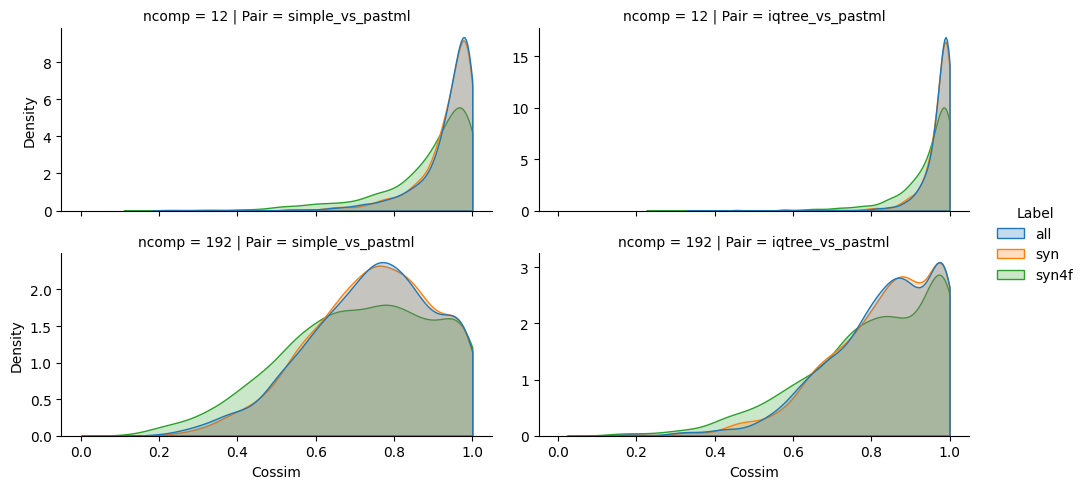

In [75]:
# 12
cossim12_total = pd.concat([
    # get_cossim(new_mutspec12_simple_wide, new_mutspec12_iqtree_wide).rename("Cossim").reset_index().assign(Pair="simple_vs_iqtree"), 
    get_cossim(new_mutspec12_simple_wide, new_mutspec12_pastml_wide).rename("Cossim").reset_index().assign(Pair="simple_vs_pastml"), 
    get_cossim(new_mutspec12_iqtree_wide, new_mutspec12_pastml_wide).rename("Cossim").reset_index().assign(Pair="iqtree_vs_pastml"),
], ignore_index=True)

# 192
cossim192_total = pd.concat([
    # get_cossim(new_mutspec192_simple_wide, new_mutspec192_iqtree_wide).rename("Cossim").reset_index().assign(Pair="simple_vs_iqtree"), 
    get_cossim(new_mutspec192_simple_wide, new_mutspec192_pastml_wide).rename("Cossim").reset_index().assign(Pair="simple_vs_pastml"), 
    get_cossim(new_mutspec192_iqtree_wide, new_mutspec192_pastml_wide).rename("Cossim").reset_index().assign(Pair="iqtree_vs_pastml"),
], ignore_index=True)


# concat 12 and 192
cossim12_total["ncomp"] = 12
cossim192_total["ncomp"] = 192
cossim_total = pd.concat([cossim12_total, cossim192_total], ignore_index=True)
cossim_total["Label"] = cossim_total["Label"].replace({"ff":"syn4f"})

sns.displot(
    data=cossim_total,
    x="Cossim", hue="Label", col="Pair", row="ncomp",
    kind="kde", fill=True, clip=(0, 1), common_norm=False, height=2.5, aspect=2,
    facet_kws=dict(sharex=True, sharey=False), 
)
plt.show()

### Legacy (for-loop)

In [53]:
sims_data12 = []
for lbl in mutspec_simple12.Label.unique():
    for anode in tqdm.tqdm(set(mutspec_simple12.AltNode), lbl):
        df1 = mutspec_simple12[(mutspec_simple12.Label == lbl) & (mutspec_simple12.AltNode == anode)].set_index("Mut").sort_index()
        df2 = mutspec_iqtree12[(mutspec_iqtree12.Label == lbl) & (mutspec_iqtree12.AltNode == anode)].set_index("Mut").sort_index()
        df3 = mutspec_pastml12[(mutspec_pastml12.Label == lbl) & (mutspec_pastml12.AltNode == anode)].set_index("Mut").sort_index()

        if len(df1) < 10 or len(df2) < 10 or len(df3) < 10:
            continue

        sim12 = 1 - spatial.distance.cosine(df1["MutSpec"], df2["MutSpec"])
        sim13 = 1 - spatial.distance.cosine(df1["MutSpec"], df3["MutSpec"])
        sim23 = 1 - spatial.distance.cosine(df2["MutSpec"], df3["MutSpec"])
        
        sims_data12.append({
            "Label": "syn4f" if lbl == "ff" else lbl, 
            "AltNode": anode, 
            "cossim simple&iqtree": sim12, "cossim simple&pastml": sim13, "cossim iqtree&pastml": sim23,
        })
sims_df12 = pd.DataFrame(sims_data12).sort_values("Label")

Processing all


100%|██████████| 2576/2576 [02:07<00:00, 20.28it/s]


Processing syn


100%|██████████| 2576/2576 [02:07<00:00, 20.27it/s]


Processing ff


100%|██████████| 2576/2576 [02:01<00:00, 21.26it/s]


In [107]:
mutspec_simple192.head()

,Mut,ObsNum,ExpNum,RawMutSpec,MutSpec,RefNode,AltNode,Label
0,A[A>G]T,1,34.0,0.029412,0.017871,Node208,Node209,all
1,A[A>T]T,1,34.0,0.029412,0.017871,Node208,Node209,all
2,A[C>T]G,1,12.0,0.083333,0.050634,Node208,Node209,all
3,A[C>T]T,1,33.0,0.030303,0.018412,Node208,Node209,all
4,A[G>C]T,2,17.0,0.117647,0.071483,Node208,Node209,all


In [16]:
sims_data192 = []
for lbl in mutspec_simple192.Label.unique():
    for anode in tqdm.tqdm(set(mutspec_simple192.AltNode), lbl):
        nmut = 50

        df1 = mutspec_simple192[(mutspec_simple192.Label == lbl) & (mutspec_simple192.AltNode == anode)].set_index("Mut").sort_index()
        if (df1.MutSpec > 0).sum() < nmut:
            continue
        df2 = mutspec_iqtree192[(mutspec_iqtree192.Label == lbl) & (mutspec_iqtree192.AltNode == anode)].set_index("Mut").sort_index()
        if (df2.MutSpec > 0).sum() < nmut:
            continue
        df3 = mutspec_pastml192[(mutspec_pastml192.Label == lbl) & (mutspec_pastml192.AltNode == anode)].set_index("Mut").sort_index()
        if (df3.MutSpec > 0).sum() < nmut:
            continue

        sim12 = 1 - spatial.distance.cosine(df1["MutSpec"], df2["MutSpec"])
        sim13 = 1 - spatial.distance.cosine(df1["MutSpec"], df3["MutSpec"])
        sim23 = 1 - spatial.distance.cosine(df2["MutSpec"], df3["MutSpec"])
        
        sims_data192.append({
            "Label": "syn4f" if lbl == "ff" else lbl, 
            "AltNode": anode, 
            "cossim simple&iqtree": sim12, "cossim simple&pastml": sim13, "cossim iqtree&pastml": sim23,
        })
sims_df192 = pd.DataFrame(sims_data192).sort_values("Label")
sims_df192.to_csv("../data/sims_df192.csv", index=False)

ff: 100%|██████████| 2576/2576 [10:20<00:00,  4.15it/s]


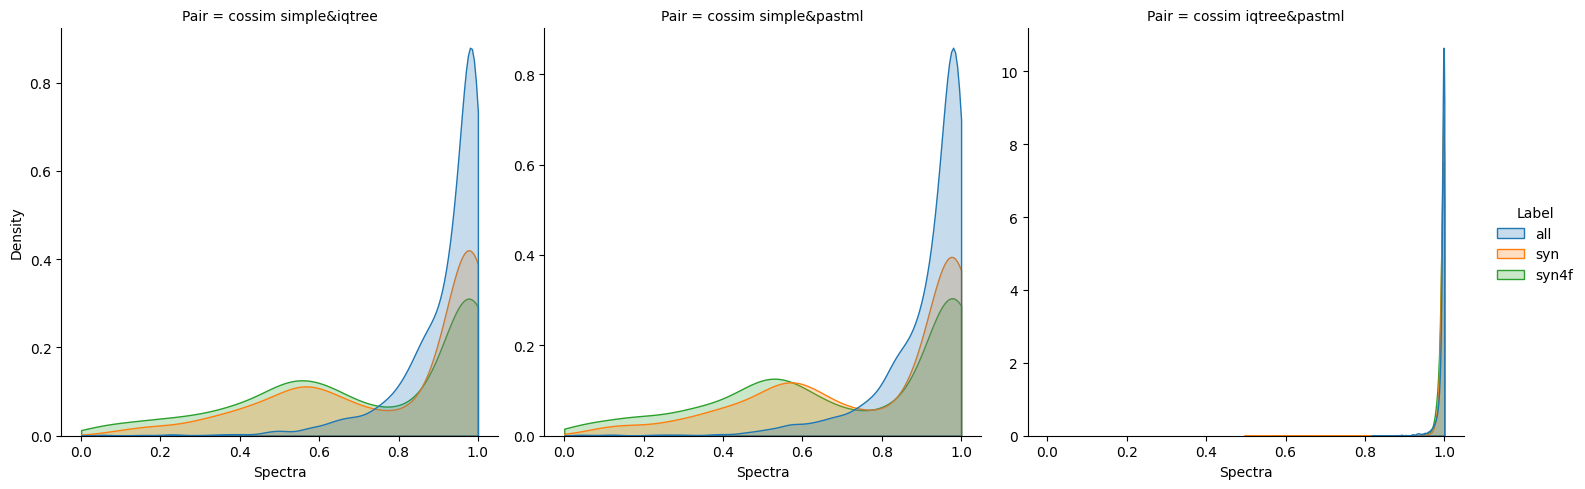

In [76]:
sns.displot(
    data=sims_df12.melt("Label", sims_df12.columns[-3:], "Pair", "Spectra"), 
    x="Spectra", col="Pair", hue="Label", 
    kind="kde", fill=True, clip=(0, 1),
    facet_kws=dict(sharex=True, sharey=False),
)

all    111
syn     42
Name: Label, dtype: int64


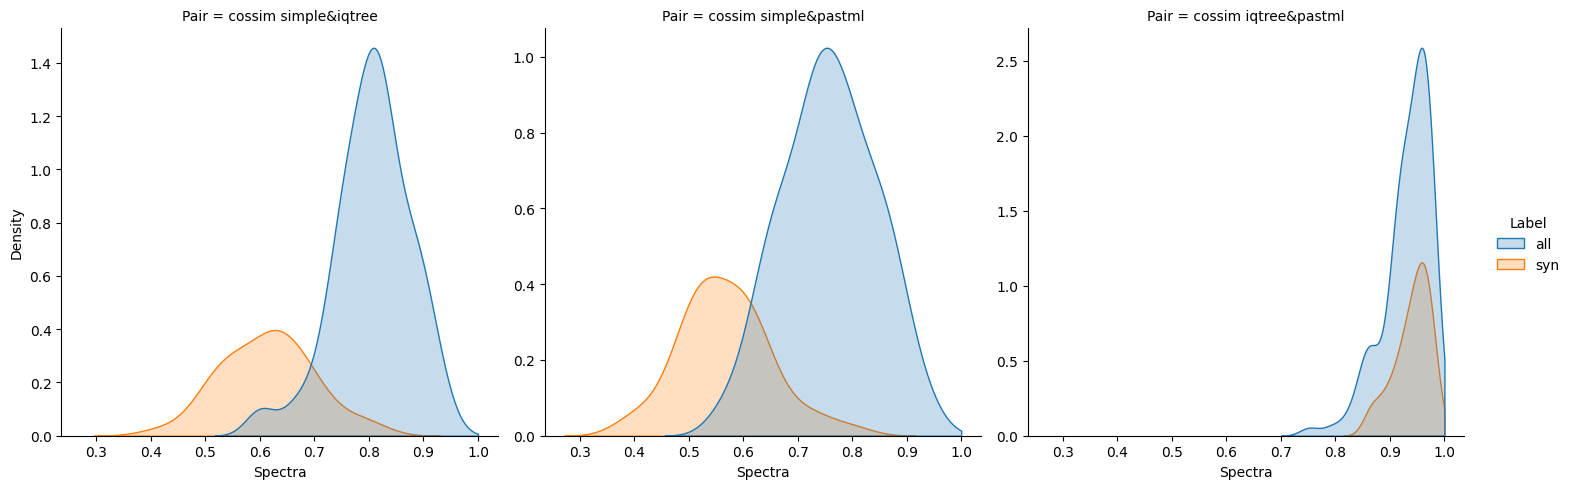

In [28]:
print(sims_df192.Label.value_counts())
sns.displot(
    data=sims_df192.melt("Label", sims_df192.columns[-3:], "Pair", "Spectra"), 
    x="Spectra", col="Pair", hue="Label", 
    kind="kde", fill=True, clip=(0, 1),
    facet_kws=dict(sharex=True, sharey=False),
)
plt.show()

## Categorizing mutations
We need to explore what mutations sample is responible for the bias

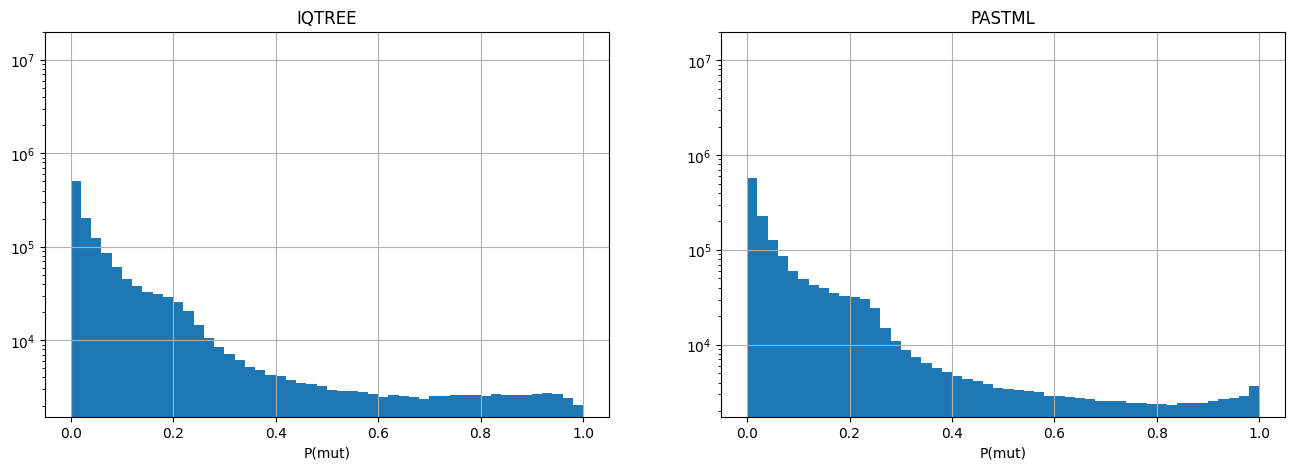

In [77]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
mut_iqtree.ProbaFull.hist(bins=50)
plt.yscale("log")
plt.title("IQTREE")
plt.xlabel("P(mut)")
plt.ylim(0, 2e7)

plt.subplot(1,2,2)
mut_pastml.ProbaFull.hist(bins=50)
plt.yscale("log")
plt.title("PASTML")
plt.xlabel("P(mut)")
plt.ylim(0, 2e7)
plt.show()

НАЛОЖИТЬ В ОДИН

Сколько мутаций в каждом интервале вероятностей у обоих подходов

In [78]:
print("p1\tp2\t#iqtree\t#pastml")
for x1 in np.linspace(0, 1, 21)[:-1]:
    x2 = x1 + 0.05
    mut_exp_num_iqtree = mut_iqtree[(mut_iqtree.ProbaFull > x1) & (mut_iqtree.ProbaFull <= x2)].ProbaFull.sum()
    mut_exp_num_pastml = mut_pastml[(mut_pastml.ProbaFull > x1) & (mut_pastml.ProbaFull <= x2)].ProbaFull.sum()
    print(f"{x1:.2f}\t{x2:.2f}\t{mut_exp_num_iqtree:.1f}\t{mut_exp_num_pastml:.1f}")

p1	p2	#iqtree	#pastml
0.00	0.05	12876.9	14248.6
0.05	0.10	14463.1	14426.2
0.10	0.15	12252.1	13799.0
0.15	0.20	13293.6	15374.8
0.20	0.25	12154.9	17041.9
0.25	0.30	7000.1	9912.9
0.30	0.35	5188.0	6330.6
0.35	0.40	4328.5	5210.0
0.40	0.45	4102.5	4733.0
0.45	0.50	3967.7	4485.9
0.50	0.55	3822.9	4448.8
0.55	0.60	3998.2	4411.0
0.60	0.65	3987.8	4420.1
0.65	0.70	4108.6	4477.6
0.70	0.75	4612.4	4591.6
0.75	0.80	5078.2	4658.7
0.80	0.85	5373.8	4889.4
0.85	0.90	5665.3	5294.5
0.90	0.95	6235.2	6162.4
0.95	1.00	5614.2	7792.0


In [8]:
def calc_tree_mutspec(mut, freqs, lbl="syn", pmin=0.0, pmax=1.0, collapse=False):
    """
    calculate tree mutspec from history files
    
    return mutspec of each edge in one table
    """
    # sample mutations
    mut = mut[(mut.ProbaFull > pmin) & (mut.ProbaFull <= pmax)]
    
    mutspec = []
    for (ref_node, alt_node), cur_mut in mut.groupby(["RefNode", "AltNode"]):
        # sample freqs
        _cur_freq_df = freqs[(freqs.Node == ref_node) & (freqs.Label == lbl)]
        cur_freq = _cur_freq_df[possible_sbs192].sum(axis=0).to_dict()

        # calculate mutspec
        ms192 = calculate_mutspec(cur_mut[cur_mut.Label >= lbl2lbl_id(lbl)], cur_freq, use_context=True, use_proba=True)
        ms192["RefNode"] = ref_node
        ms192["AltNode"] = alt_node
        ms192["Label"] = lbl
        mutspec.append(ms192)
    mutspec_df = pd.concat(mutspec)
    if collapse:
        mutspec_df = mutspec_df.groupby(["RefNode", "AltNode", "Label"]).apply(collapse_mutspec).reset_index()
    mutspec_df["MutBase"] = mutspec_df.Mut.str.slice(2, 5)
    mutspec_df["Context"] = mutspec_df.Mut.str.get(0) + mutspec_df.Mut.str.get(2) + mutspec_df.Mut.str.get(-1)
    return mutspec_df

In [9]:
space = [0.00, 0.05, 0.30, .50, 0.80, 1.00]

In [10]:
for p1, p2 in zip(space[:-1], space[1:]):
    mut_exp_num_iqtree = mut_iqtree[(mut_iqtree.ProbaFull > p1) & (mut_iqtree.ProbaFull <= p2)].ProbaFull.sum()
    mut_exp_num_pastml = mut_pastml[(mut_pastml.ProbaFull > p1) & (mut_pastml.ProbaFull <= p2)].ProbaFull.sum()
    print(f"{p1:.2f}\t{p2:.2f}\t{mut_exp_num_iqtree:.1f}\t{mut_exp_num_pastml:.1f}")

0.00	0.05	12876.9	14248.6
0.05	0.30	59163.7	70554.7
0.30	0.50	17586.7	20759.4
0.50	0.80	25608.1	27007.8
0.80	1.00	22888.5	24138.3


In [11]:
ms_cat_iqtree = []
for p1, p2 in zip(space[:-1], space[1:]):
    ms = calc_tree_mutspec(mut_iqtree, freqs_iqtree, "syn_c", p1, p2)
    ms["Cat"] = f"{p1:.2f}_{p2:.2f}"
    ms_cat_iqtree.append(ms)

ms_cat_iqtree_df = pd.concat(ms_cat_iqtree)

In [12]:
ms_cat_pastml = []
for p1, p2 in zip(space[:-1], space[1:]):
    ms = calc_tree_mutspec(mut_pastml, freqs_pastml, "syn_c", p1, p2)
    ms["Cat"] = f"{p1:.2f}_{p2:.2f}"
    ms_cat_pastml.append(ms)

ms_cat_pastml_df = pd.concat(ms_cat_pastml)

### Categorized mutspec 

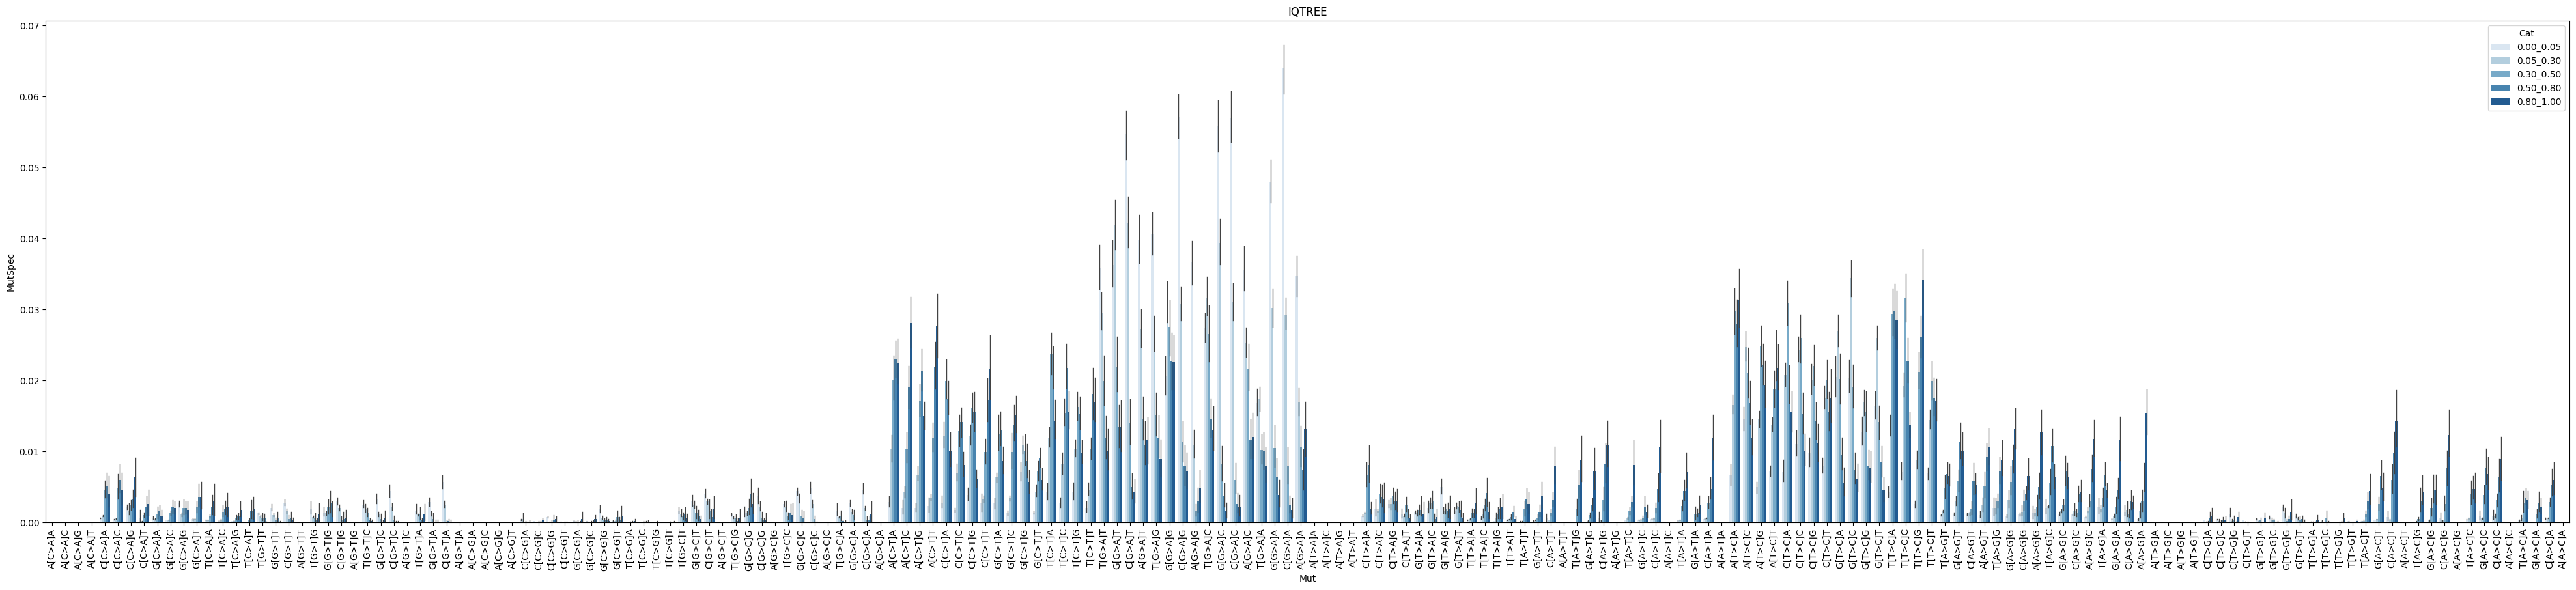

In [15]:
plt.figure(figsize=(50, 10))
sns.barplot(
    x="Mut", y="MutSpec", hue="Cat", data=ms_cat_iqtree_df, errwidth=1, order=ordered_sbs192_kp, palette="Blues",
)
plt.title("IQTREE")
plt.xticks(rotation=90);
plt.savefig("../figures/mammals_cytb_iqtree_mut_proba_cats.svg", bbox_inches="tight")
plt.savefig("../figures/mammals_cytb_iqtree_mut_proba_cats.pdf", bbox_inches="tight")
plt.show()

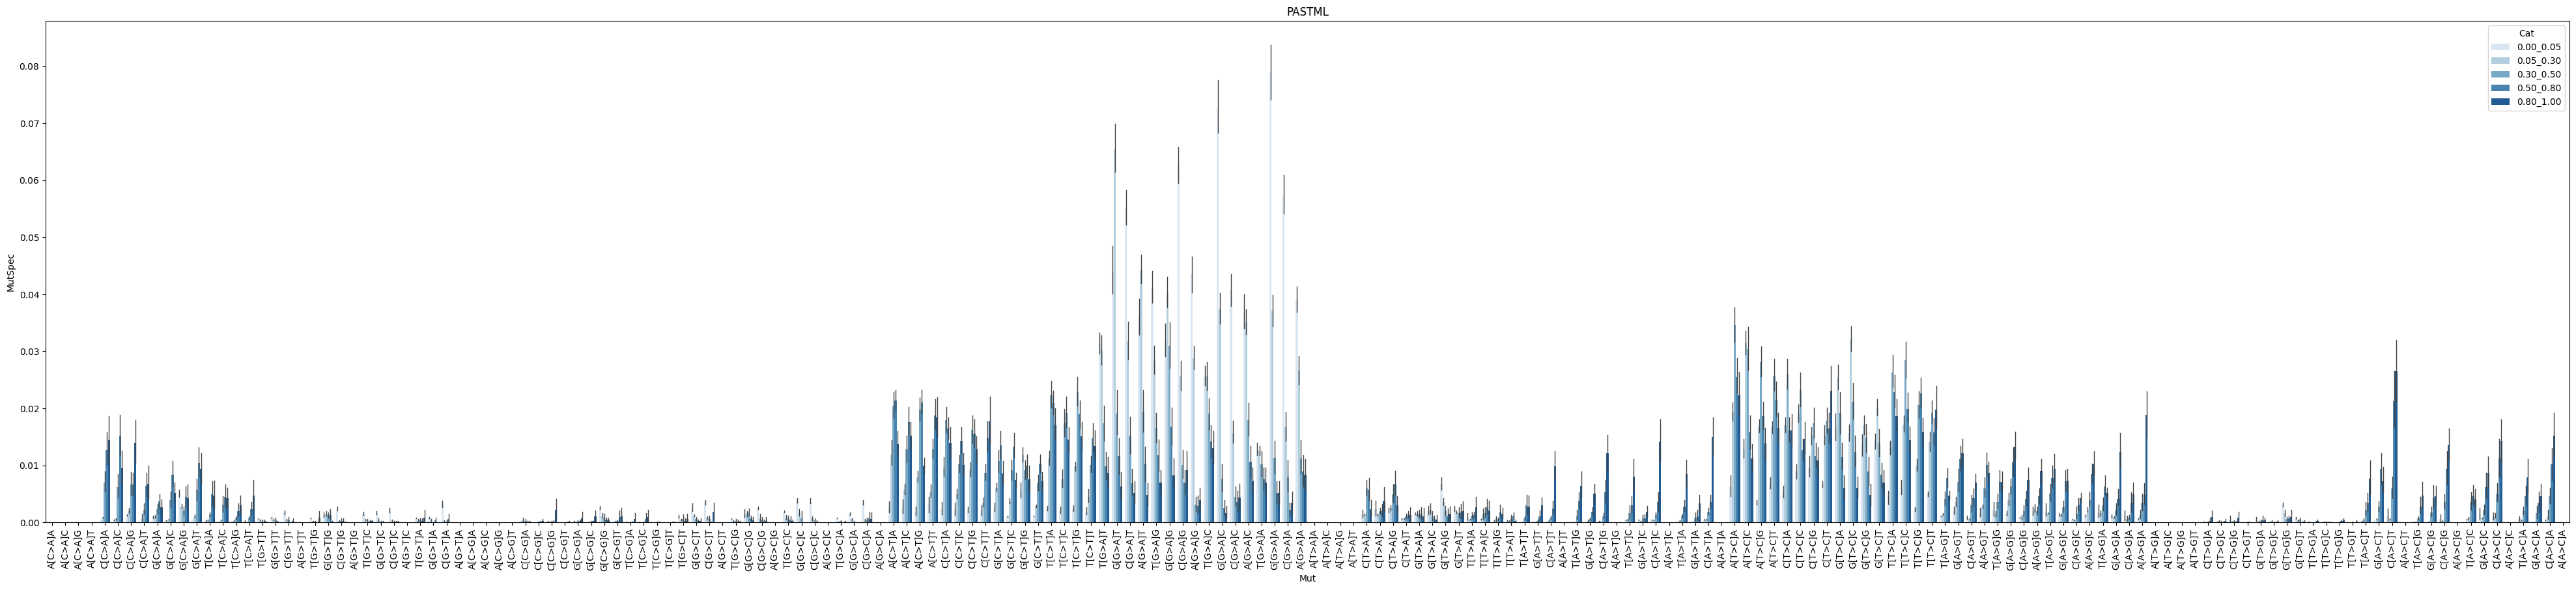

In [16]:
plt.figure(figsize=(50, 10))
sns.barplot(
    x="Mut", y="MutSpec", hue="Cat", data=ms_cat_pastml_df, errwidth=1, order=ordered_sbs192_kp, palette="Blues",
)
plt.title("PASTML")
plt.xticks(rotation=90)
plt.savefig("../figures/mammals_cytb_pastml_mut_proba_cats.svg", bbox_inches="tight")
plt.savefig("../figures/mammals_cytb_pastml_mut_proba_cats.pdf", bbox_inches="tight")
plt.show()

Разглядывать сложно. Но виден сильный дисбаланс.Как по низковероятным мутациям, так и по высоковероятным

### Compare cossim of mutspecs on mutations samples

In [28]:
def plot_compared(p1, p2, lbl="syn", constant_pastml=False):
    ms_simple = mutspec_simple192[(mutspec_simple192.Label == lbl)]
    ms_iqtree = calc_tree_mutspec(mut_iqtree, freqs_iqtree, lbl, p1, p2)
    if constant_pastml:
        ms_pastml = calc_tree_mutspec(mut_pastml, freqs_pastml, lbl, 0, 1)
    else:
        ms_pastml = calc_tree_mutspec(mut_pastml, freqs_pastml, lbl, p1, p2)
    sims_data = []
    for anode in set(mutspec_simple192.AltNode):
        df1 = ms_simple[(ms_simple.AltNode == anode)].set_index("Mut").sort_index()
        df2 = ms_iqtree[(ms_iqtree.AltNode == anode)].set_index("Mut").sort_index()
        df3 = ms_pastml[(ms_pastml.AltNode == anode)].set_index("Mut").sort_index()
        if not df1.shape or not df2.shape or not df3.shape:
            continue

        sim12 = 1 - spatial.distance.cosine(df1["MutSpec"], df2["MutSpec"])
        sim13 = 1 - spatial.distance.cosine(df1["MutSpec"], df3["MutSpec"])
        sim23 = 1 - spatial.distance.cosine(df2["MutSpec"], df3["MutSpec"])
        
        sims_data.append({"AltNode": anode, "Pair": "simple & iqtree", "Cossim": sim12})
        sims_data.append({"AltNode": anode, "Pair": "iqtree & pastml", "Cossim": sim23})
        sims_data.append({"AltNode": anode, "Pair": "simple & pastml", "Cossim": sim13})

    sims_df = pd.DataFrame(sims_data)
    
    # https://python.plainenglish.io/ridge-plots-with-pythons-seaborn-4de5725881af
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
    palette = sns.color_palette("Set2", 12)
    g = sns.FacetGrid(sims_df, palette=palette, row="Pair", hue="Pair", aspect=4, height=2.0)
    g.map_dataframe(sns.kdeplot, x="Cossim", fill=True, alpha=1)
    g.map_dataframe(sns.kdeplot, x="Cossim", color='black')

    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, color='black', fontsize=13,
                ha="left", va="center", transform=ax.transAxes)
        
    g.map(label, "Pair")
    g.fig.subplots_adjust(hspace=-.5)
    g.set_titles("")
    g.set(yticks=[], xlabel="cossim", ylabel="")
    g.despine(left=True)
    title = f"Proba: ({p1}, {p2}]"
    if constant_pastml:
        title = f"Proba: iqtree: ({p1}, {p2}]; pastml: (0, 1]"
    plt.suptitle(title, y=0.98)
    plt.xlim(0, 1.01)
    plt.xticks(np.linspace(-0.1, 1.1, 13))
    plt.show()

Ниже графики, в которых мутспек считается по подвыборке мутаций с указанной вероятностью. 

Сначала идут графики, где мутации фильтровались как для iqtree, так и для pastml. Далее идут графики, где мутации фильтруются только у iqtree

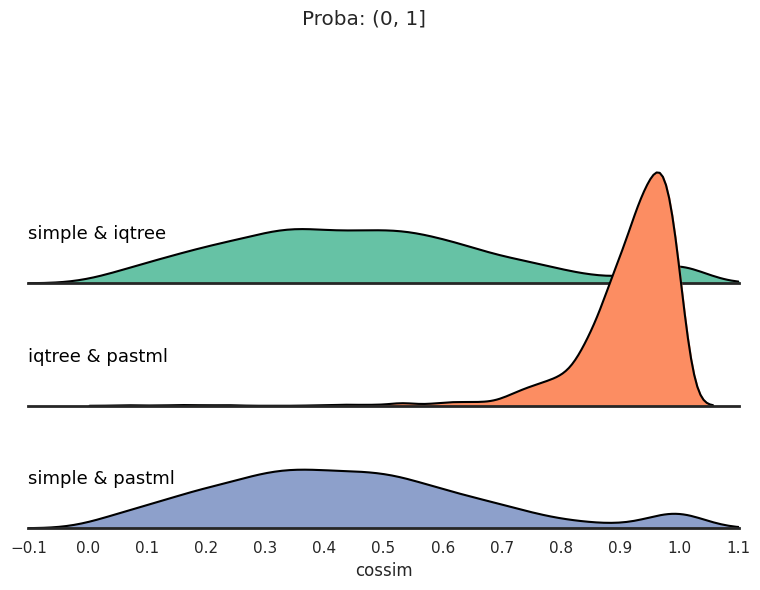

In [19]:
plot_compared(0, 1)

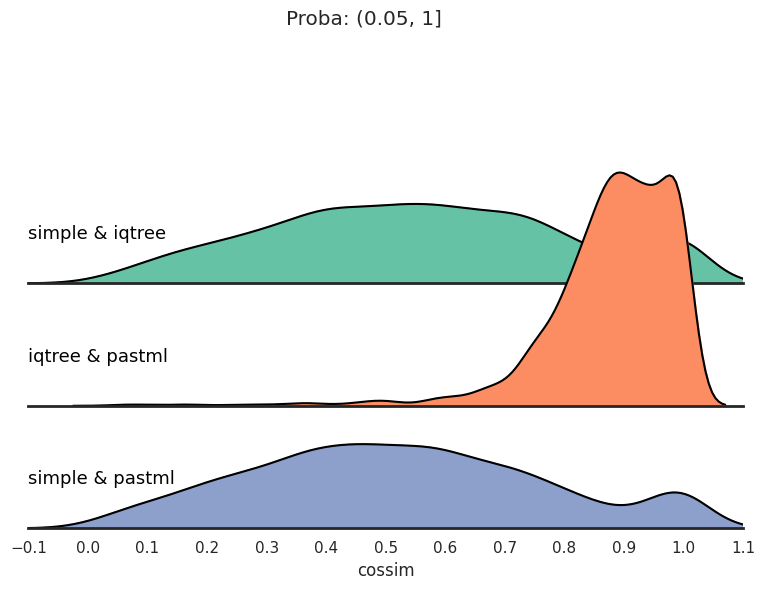

In [20]:
plot_compared(0.05, 1)

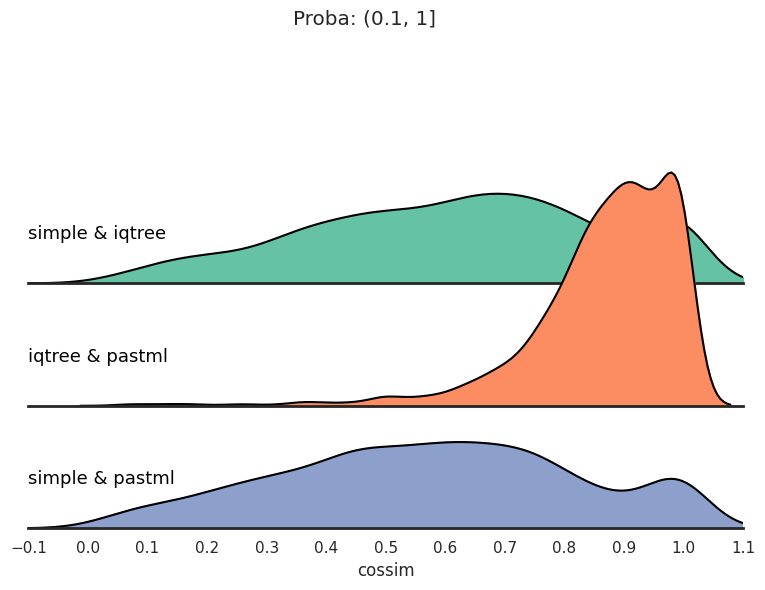

In [21]:
plot_compared(0.1, 1)

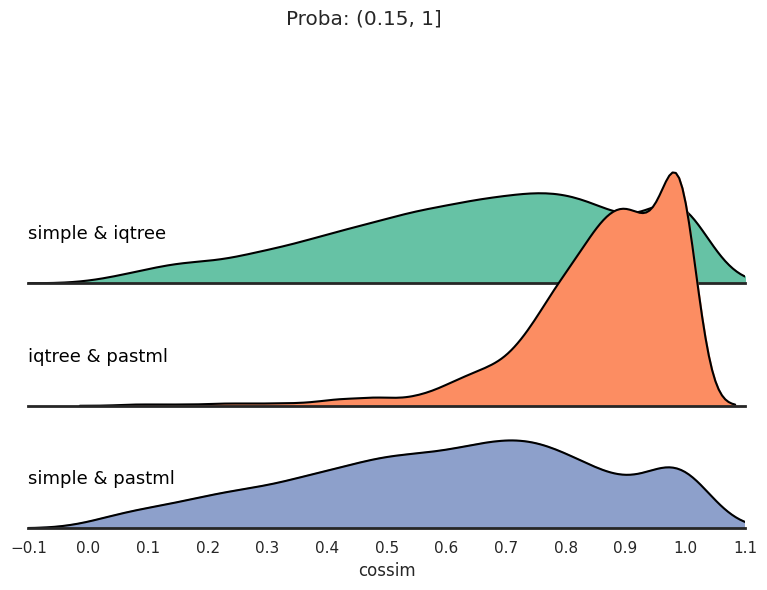

In [22]:
plot_compared(0.15, 1)

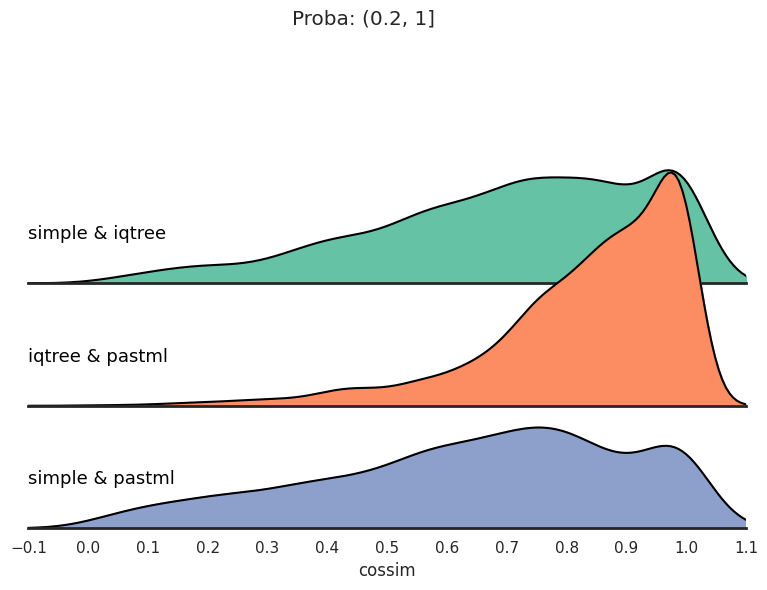

In [23]:
plot_compared(0.20, 1)

In [29]:
plot_compared(0.40, 1)

ValueError: operands could not be broadcast together with shapes (192,) (0,) 

Далее полная выборка мутаций из pastml сравнивается с разными выборками из iqtree

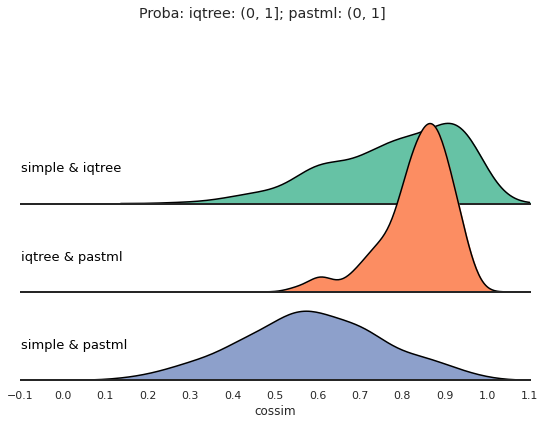

In [ ]:
plot_compared(0, 1, constant_pastml=True)

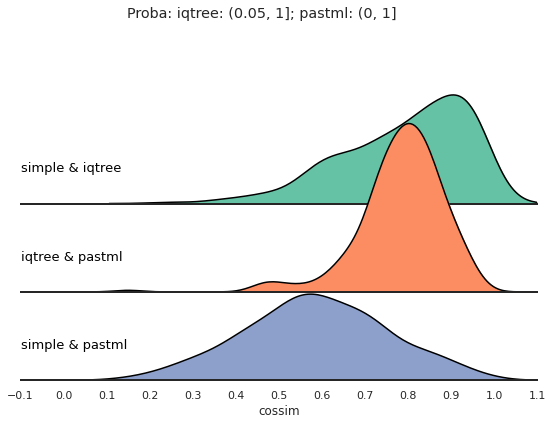

In [ ]:
plot_compared(0.05, 1, constant_pastml=True)

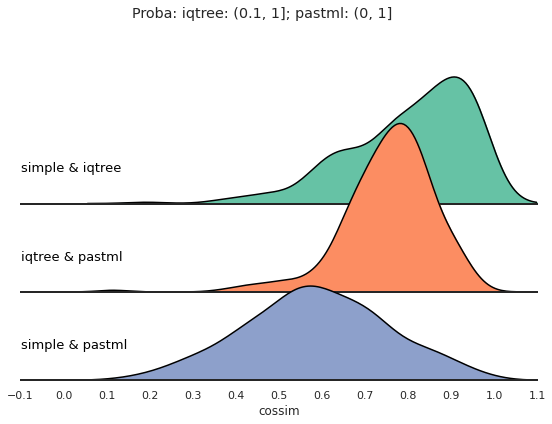

In [ ]:
plot_compared(0.1, 1, constant_pastml=True)

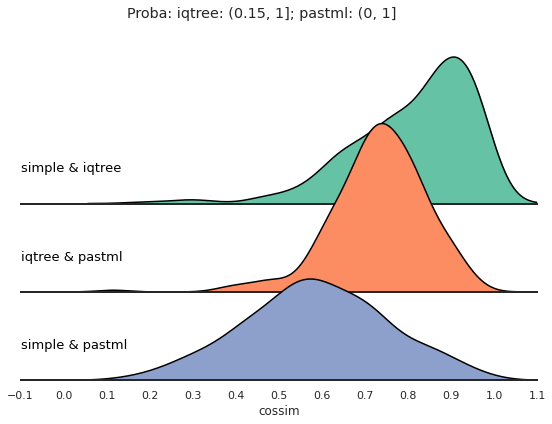

In [ ]:
plot_compared(0.15, 1, constant_pastml=True)